In [2]:
import os
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torchvision 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision import datasets, models, transforms

c:\Users\micha\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Nie można odnaleźć określonej procedury
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# batch_size = 128
# num_workers = 4

# transform = transforms.Compose([transforms.ToTensor(),                                
#                                 transforms.Normalize(mean=[0.5], std=[0.5]),
#                                 transforms.Resize(size=[int(218/4), int(178/4)])
#                                 transforms.CenterCrop((16*2,16*2))])

# data_path = '../../googlenet-main/data/celeba'

# dataset = ImageFolder(data_path, transform)
# train_loader = DataLoader(dataset=dataset,
#                           batch_size=batch_size,
# #                           num_workers=num_workers,
#                           drop_last=True,)


In [4]:
# fig, ax  = plt.subplots(10,10, figsize=(40,30))
# img = next(iter(train_loader))[0]
# for i in range(10):
#     for j in range(10):
#         ax[i,j].imshow(img[i+10*j].numpy().T)


In [5]:
def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader, loss_fn=None,
                 logging_interval=100, 
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device[0])

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
            
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var) ,
                                      axis=1).to('cuda:0') # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension

            pixelwise = loss_fn(decoded, features.to('cuda:0'), reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean().to('cuda:0') # average over batch dimension
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        fig, ax = plt.subplots(10,10, figsize=(64, 48))
        img = decoded.detach().cpu().numpy()
        img1 = features.detach().cpu().numpy()
        for i in range(5):
            for j in range(10):
                ax[j,i].imshow(img1[i+10*j].T)
                ax[j,i+5].imshow(img[i+10*j].T)
        plt.show()
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

In [6]:
def train_gan_v1(num_epochs, model,
                 latent_dim, device, train_loader, loss_fn=None,
                 logging_interval=100, b=128,
                 save_model=None):
    print("training1")
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}
    
    torch.autograd.set_detect_anomaly(True)
    
    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    lr = 0.0001
    start_time = time.time()
    fixed_noise = torch.randn(next(iter(train_loader))[0].size()[0], latent_dim, 1, 1,  device=device[0])  # format NCHW
    for epoch in range(num_epochs):
#         if(epoch<=int(num_epochs/2)-1):
#             lr+=0.00005
#         else:
#             lr-=0.00005
            
        optimizer_discr  = torch.optim.Adam(model.discriminator.parameters(),
                                       betas=(0.5, 0.999),
                                       lr=lr)

        optimizer_gen = torch.optim.Adam(model.generator.parameters(),
                                     betas=(0.5, 0.999),
                                     lr=lr)

        model.train()
        for batch_idx, (features,_) in enumerate(train_loader):
            batch_size = features.size(0)
            # batch_size = np.shape(next(iter(features))[1])

            # real images
            real_images = features.to(device[1])
            real_labels = torch.ones(batch_size, device=device[1]) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1,  device=device[0])  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device[1]) # fake label = 0
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.to(device[1])).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            
            discr_loss = 0.5*(real_loss + fake_loss)
            
            ###uncomment durring dicriminator trainning!!!
            
            discr_loss.backward(retain_graph=True)

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images.to(device[1])).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward(retain_graph=True)

            optimizer_gen.step()
            
            # --------------------------
            # Logging
            # --------------------------   
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       % (epoch+1, num_epochs, batch_idx, 
                          len(train_loader), gener_loss.item(), discr_loss.item()))
            
        ### Save images for evaluation
#         with torch.no_grad():
#             fake_images = model.generator_forward(fixed_noise).detach().cpu()
#             log_dict['images_from_noise_per_epoch'].append(
#                 torchvision.utils.make_grid(fake_images, padding=2, normalize=True))
        fake_images = model.generator_forward(fixed_noise)
        y = model.discriminator_forward(fake_images.to('cuda:0')).detach().cpu().numpy()
        fake_images = fake_images.detach().cpu().numpy()
        print(len(y))
        print(batch_size)
        a = np.append(y.T, [np.arange(128).astype(np.int32)],axis=0).T.tolist()
        a.sort(key = lambda x: x[0])
        a = a[::-1]
        np.array(a).T[1].astype(np.int)
        aa = np.array(a).T[0].astype(np.float16)
        img1 = fake_images[np.array(a).T[1].astype(np.int)]
        fig, ax = plt.subplots(10,10, figsize=(64, 48))
        for i in range(10):
            for j in range(10):
                ax[j,i].imshow(img1[i+10*j].T)
                ax[j,i].set_title(aa[i+10*j].T)
        plt.show()
        print('lol')
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict


In [7]:
def train_vae_gan_v1(num_epochs, model,
                  device, train_loader, loss_fn=None,
                 logging_interval=100, b=128,
                 reconstruction_term_weight=1,
                 v_t_g=1, #vae to gan weight
                 save_model=None):
    print("training1")
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}
    
    torch.autograd.set_detect_anomaly(True)
    
    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    lr = 0.0001
    start_time = time.time()
    for epoch in range(num_epochs):
#         if(epoch<=int(num_epochs/2)-1):
#             lr+=0.00005
#         else:
#             lr-=0.00005
            
        optimizer_discr  = torch.optim.Adam(model.discriminator.parameters(),
                                       betas=(0.5, 0.999),
                                       lr=lr)

        optimizer_gen = torch.optim.Adam(model.generator.parameters(),
                                     betas=(0.5, 0.999),
                                     lr=lr)

        model.train()
        for batch_idx, (features,_) in enumerate(train_loader):
            batch_size = features.size(0)
            # batch_size = np.shape(next(iter(features))[1])
            # real images
            real_images = features.to(device[1])
            real_labels = torch.ones(batch_size, device=device[1]) # real label = 1

            # generated (fake) images
            # noise = torch.randn(batch_size, latent_dim, 1, 1,  device=device[0])  # format NCHW
            encoded, z_mean, z_log_var,fake_images = model.generator_forward(features.to(device[0]))
            fake_labels = torch.zeros(batch_size, device=device[1]) # fake label = 0
            flipped_fake_labels = real_labels # here, fake label = 1
            
            # --------------------------
            # Train Discriminator
            # --------------------------
            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.to(device[1])).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            
            discr_loss = 0.5*(real_loss + fake_loss)
            
            ###uncomment durring dicriminator trainning!!!
            
            discr_loss.backward(retain_graph=True)

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                    - z_mean**2 
                                    - torch.exp(z_log_var), 
                                    axis=1).to(device[0]) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension

            pixelwise = loss_fn(fake_images, features.to(device[0]), reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean().to(device[0]) # average over batch dimension
            loss = reconstruction_term_weight*pixelwise + kl_div
            

            # loss.backward(retain_graph=True)

            # UPDATE MODEL PARAMETERS
            # get discriminator loss on fake images with flipped labels

            discr_pred_fake = model.discriminator_forward(fake_images.to(device[1])).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)

            gener_loss.backward(retain_graph=True)

            optimizer_gen.step()
            
            # --------------------------
            # Logging
            # --------------------------   
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       % (epoch+1, num_epochs, batch_idx, 
                          len(train_loader), gener_loss.item(), discr_loss.item()))
            
        ### Save images for evaluation
#         with torch.no_grad():
#             fake_images = model.generator_forward(fixed_noise).detach().cpu()
#             log_dict['images_from_noise_per_epoch'].append(
#                 torchvision.utils.make_grid(fake_images, padding=2, normalize=True))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        fig, ax = plt.subplots(10,10, figsize=(64, 48))
        img = fake_images.detach().cpu().numpy()
        img1 = features.detach().cpu().numpy()
        for i in range(5):
            for j in range(10):
                ax[j,i].imshow(img1[i+10*j].T)
                ax[j,i+5].imshow(img[i+10*j].T)
        plt.show()
        print('lol')
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict


In [8]:
##########################
### MODEL
##########################

class VAE1(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()
        
        
        self.generator1 = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8, 
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*8 x 4 x 4
            #
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*8, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4, 
                               kernel_size=3, stride=1, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            #
        )
        
        self.discriminator1 = nn.Sequential(
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feat_maps_dis*8, num_feat_maps_dis*8,
                      kernel_size=3, stride=1, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(num_feat_maps_dis*8, 100,
                      kernel_size=4, stride=1, padding=0),
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #
            
        )

        
        self.decoder = nn.Sequential(
            self.generator1,
            nn.ConvTranspose2d(num_feat_maps_gen*4, color_channels, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: color_channels x 64 x 64
            #  
            nn.Tanh()
        )
        self.encoder = nn.Sequential(    

            #
            # input size color_channels x image_height x image_width
            #
            nn.Conv2d(color_channels, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            
            self.discriminator1,
            
            # size: 1 x 1 x 1
            nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(100,100)
        self.z_log_var = torch.nn.Linear(100,100)

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.size(0),1,1,100)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        x = x.reshape(x.size(0),100,1,1)
        decoded = self.decoder(x)
        return encoded, z_mean, z_log_var, decoded


In [54]:
##########################
### MODEL
##########################

class VAE2(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3, gan1=None):
        super().__init__()
        if gan1 == None:
            self.gan1 = VAE1()
        else:
            self.gan1 = gan1

        
        # self.c1 = nn.Conv2d(256,128,4,2,1)
        # self.c2 = nn.Conv2d(128,100,4,1,0)

        self.c1 = nn.Conv2d(128*2,128,4,2,1)
        self.c2 = nn.Conv2d(128,100,2,1,0)
        self.m = nn.MaxPool2d(2)        
        self.cT1 = nn.ConvTranspose2d(100,128,4,1,0)
        self.cT2 = nn.ConvTranspose2d(128,256,4,2,1)
        
        self.generator1 = nn.Sequential(
            self.gan1.generator1,
            #
            # size if latent_dim=100: num_feat_maps_gen*4 x 8 x 8
            #
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*4, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2, 
                               kernel_size=3, stride=1, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
        )
        
        self.discriminator1 = nn.Sequential(
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),   
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*4,
                      kernel_size=3, stride=1, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*4 x 8 x 8
            #  
            self.gan1.discriminator1,
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #
            
        )

        self.generator2 = nn.Sequential(
            # self.gan1.generator1,
            #
            # size if latent_dim=100: num_feat_maps_gen*4 x 8 x 8
            #
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*4, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2, 
                               kernel_size=3, stride=1, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
        )
        
        self.discriminator2 = nn.Sequential(
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),   
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*4,
                      kernel_size=3, stride=1, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*4 x 8 x 8
            #  
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #
            
        )

        
        self.decoder = nn.Sequential(
            self.generator2,
            nn.ConvTranspose2d(num_feat_maps_gen*2, color_channels, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: color_channels x 64 x 64
            #  
            nn.Tanh()
        )
        self.encoder = nn.Sequential(    

            #
            # input size color_channels x image_height x image_width
            #
            nn.Conv2d(color_channels, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            
            self.discriminator2,

            # nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*4,
            #           kernel_size=4, stride=1, padding=0),
            
            # size: 1 x 1 x 1
            # nn.Flatten(),
        )
        
        self.z_mean = self.gan1.z_mean 
        # torch.nn.Linear(100,100)
        # .to('cuda:0')
        self.z_log_var = self.gan1.z_log_var
        # torch.nn.Linear(100,100)
        # .to('cuda:0')

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

         
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z
        
        
    def forward(self, x):
        x = self.encoder(x)
        identity = x
        identity = self.gan1.generator1(self.gan1.discriminator1(identity))
        x = self.m(x) 
        x = self.c1(x) 
        x = self.c2(x) 
        x = x.reshape(x.size(0),1,1,100)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        x = x.reshape(x.size(0),100,1,1)
        encoded = self.reparameterize(z_mean, z_log_var)
        x = self.cT1(x)
        x = self.cT2(x)
        x += identity
        
        decoded = self.decoder(x)
        return encoded, z_mean, z_log_var, decoded


In [118]:
v2 = VAE2()
v2.encoder(torch.randn(5,3,32,32)).size()

torch.Size([5, 256, 8, 8])

In [11]:
vv = VAE1()
vv.decoder(vv.encoder(torch.randn(10,3,16,16)).reshape(10,100,1,1)).size()

torch.Size([10, 3, 16, 16])

In [14]:
# for i in v.children():
#     for j in i.parameters(): print(i)

In [16]:
cc2 = nn.Conv2d(256,128,5,1,0)
cc100 = nn.Conv2d(128,100,4,1,0)
ccT100 = nn.ConvTranspose2d(100,128,4,1,0)
ccT2 = nn.ConvTranspose2d(128,256,5,1,0)

In [17]:
##########################
### MODEL
##########################

class VAE3(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()
        self.gan1 = VAE2()
        
        self.generator1 = nn.Sequential(
            # self.gan1.generator1,
            # #
            # # size if latent_dim=100: num_feat_maps_gen*2 x 16 x 16
            #
            nn.ConvTranspose2d(100,128,4,1,0),
            nn.ConvTranspose2d(128,256,5,1,0),
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen*2, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen, 
                               kernel_size=3, stride=1, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),
            
            # size if latent_dim=100: num_feat_maps_gen x 32 x 32
            #
        )
        
        self.discriminator1 = nn.Sequential(
            #
            # size: num_feat_maps_dis x 32 x 32
            #              
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            #             
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*2,
                      kernel_size=3, stride=1, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            # nn.Conv2d(256,128,5,1,0),
            # nn.Conv2d(128,100,4,1,0),
            #
            # # size: num_feat_maps_dis*2 x 16 x 16
            #   
            #
            # size: num_feat_maps_dis*4 x 8 x 8
            #  
            # self.gan1.discriminator1,
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #
            
        )

        
        self.decoder = nn.Sequential(
            self.generator1,
            nn.ConvTranspose2d(num_feat_maps_gen, color_channels, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: color_channels x 64 x 64
            #  
            nn.Tanh()
        )
        self.encoder = nn.Sequential(    

            #
            # input size color_channels x image_height x image_width
            #
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            
            self.discriminator1,

            # nn.Conv2d(num_feat_maps_dis*8, 100,
            #           kernel_size=4, stride=1, padding=0),
            
            # size: 1 x 1 x 1
            # nn.Flatten(),
        )        
        self.z_mean = self.gan1.z_mean 
        # torch.nn.Linear(100,100)
        # .to('cuda:0')
        self.z_log_var = self.gan1.z_log_var
        # torch.nn.Linear(100,100)
        # .to('cuda:0')

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        # .to('cuda:0')
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.size(0),1,1,100)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        x = x.reshape(x.size(0),100,1,1)
        decoded = self.decoder(x)
        return encoded, z_mean, z_log_var, decoded
        
    def forward(self, x):
        x = self.encoder(x)
        identity = x
        identity = self.gan1.generator1(self.gan1.discriminator1(identity))
        x = self.c1(x) 
        x = self.c2(x) 
        x = x.reshape(x.size(0),1,1,100)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        x = x.reshape(x.size(0),100,1,1)
        encoded = self.reparameterize(z_mean, z_log_var)
        x = self.cT1(x)
        x = self.cT2(x)
        x += identity
        
        decoded = self.decoder(x)
        return encoded, z_mean, z_log_var, decoded


In [65]:
inp = nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1)

In [68]:
inp(torch.randn(5,3,128,128)).size()

torch.Size([5, 64, 128, 128])

In [125]:
xd = nn.Conv2d(128,128,8,4,2)
xd1 = nn.Conv2d(128,128,8,4,0)
xd2 = nn.Upsample(32)

In [132]:
img = torch.randn(5,3,16,16)
img2 = xd2(img)
img2.size()

torch.Size([5, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


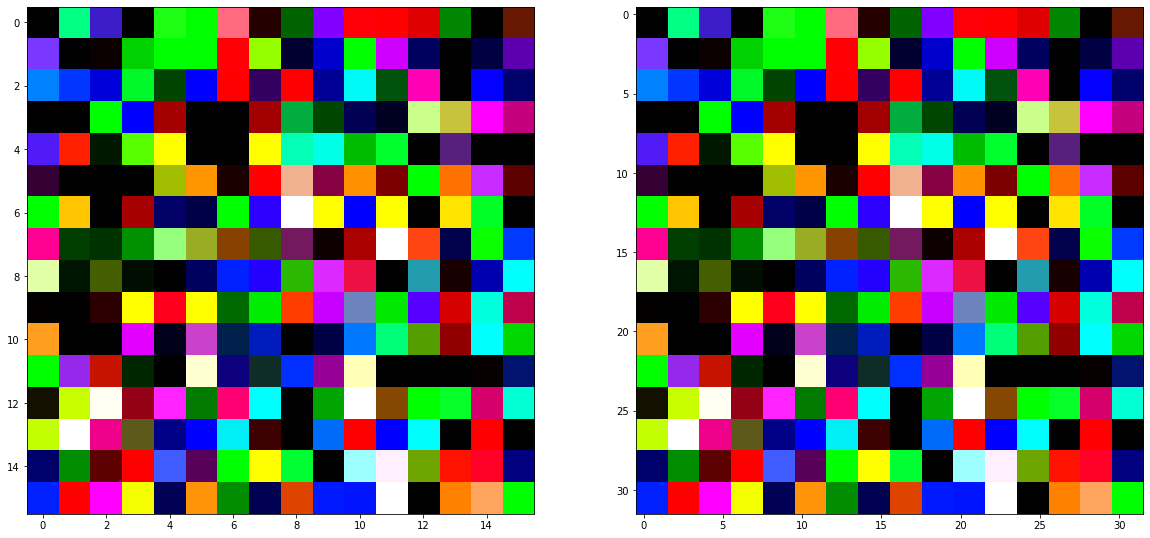

In [136]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(img.detach().numpy()[0].T)
ax[1].imshow(img2.detach().numpy()[0].T)


In [75]:
vv3 = VAE3()
s=32*2
xd(

# c4(c3(c2(c1(
vv3.discriminator1(
inp(
# vv2.discriminator1(
# vv3.decoder(
torch.randn(10,3,s,s)
))
# ))
).size()
# .reshape(10,100,1,1)).size()
# vv3(torch.randn(5,3,s,s))

torch.Size([10, 128, 8, 8])

In [161]:
c1 = nn.Conv2d(256//2,128,5,3,0)
c2 = nn.Conv2d(128,128,4,1,0)
c3 = nn.Conv2d(256//2,128,5,1,0)
c4 = nn.Conv2d(128*2,128,4,2,1)
c6 = nn.Conv2d(128,100,2,1,0)
m = nn.MaxPool2d(2)
ct4 = nn.ConvTranspose2d(128,128*2,4,2,1)
ct6 = nn.ConvTranspose2d(100,128,2,2,0)
u = nn.Upsample(2)
c5 = nn.Conv2d(128,100,3,1,1)

In [163]:
ct4(
ct6(
u(
torch.randn(5,100,1,1)
)
)
).size()

torch.Size([5, 256, 8, 8])

In [165]:
vv = VAE2()
vv.decoder(
ct4(
ct6(
u(
c6(
c4(
m(
vv.encoder(torch.randn(10,3,32,32)
)))
)))
)).size()

torch.Size([10, 3, 32, 32])

In [ ]:
nn.concat

In [99]:
# c5(
# m(
xd(
xd1(
torch.randn(5,128,32,32)
)
# )
).size()

torch.Size([5, 128, 1, 1])

In [20]:
vv3 = VAE3()
s=32*2

# c4(c3(c2(c1(
vv3.discriminator1(
# vv2.discriminator1(
# vv3.decoder(
torch.randn(10,3,s,s)
# ))
# ))
).size()
# .reshape(10,100,1,1)).size()
# vv3(torch.randn(5,3,s,s))

torch.Size([10, 128, 16, 16])

Epoch: 001/002 | Batch 0000/1582 | Loss: 2307.3940
Epoch: 001/002 | Batch 0050/1582 | Loss: 367.6323
Epoch: 001/002 | Batch 0100/1582 | Loss: 277.3418
Epoch: 001/002 | Batch 0150/1582 | Loss: 222.8302
Epoch: 001/002 | Batch 0200/1582 | Loss: 205.6220
Epoch: 001/002 | Batch 0250/1582 | Loss: 184.4465
Epoch: 001/002 | Batch 0300/1582 | Loss: 157.3708
Epoch: 001/002 | Batch 0350/1582 | Loss: 164.4794
Epoch: 001/002 | Batch 0400/1582 | Loss: 151.7917
Epoch: 001/002 | Batch 0450/1582 | Loss: 148.4114
Epoch: 001/002 | Batch 0500/1582 | Loss: 138.7057
Epoch: 001/002 | Batch 0550/1582 | Loss: 138.5893
Epoch: 001/002 | Batch 0600/1582 | Loss: 132.8516
Epoch: 001/002 | Batch 0650/1582 | Loss: 127.2292
Epoch: 001/002 | Batch 0700/1582 | Loss: 136.8994
Epoch: 001/002 | Batch 0750/1582 | Loss: 124.5977
Epoch: 001/002 | Batch 0800/1582 | Loss: 115.5088
Epoch: 001/002 | Batch 0850/1582 | Loss: 107.6928
Epoch: 001/002 | Batch 0900/1582 | Loss: 112.7608
Epoch: 001/002 | Batch 0950/1582 | Loss: 111.9715

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

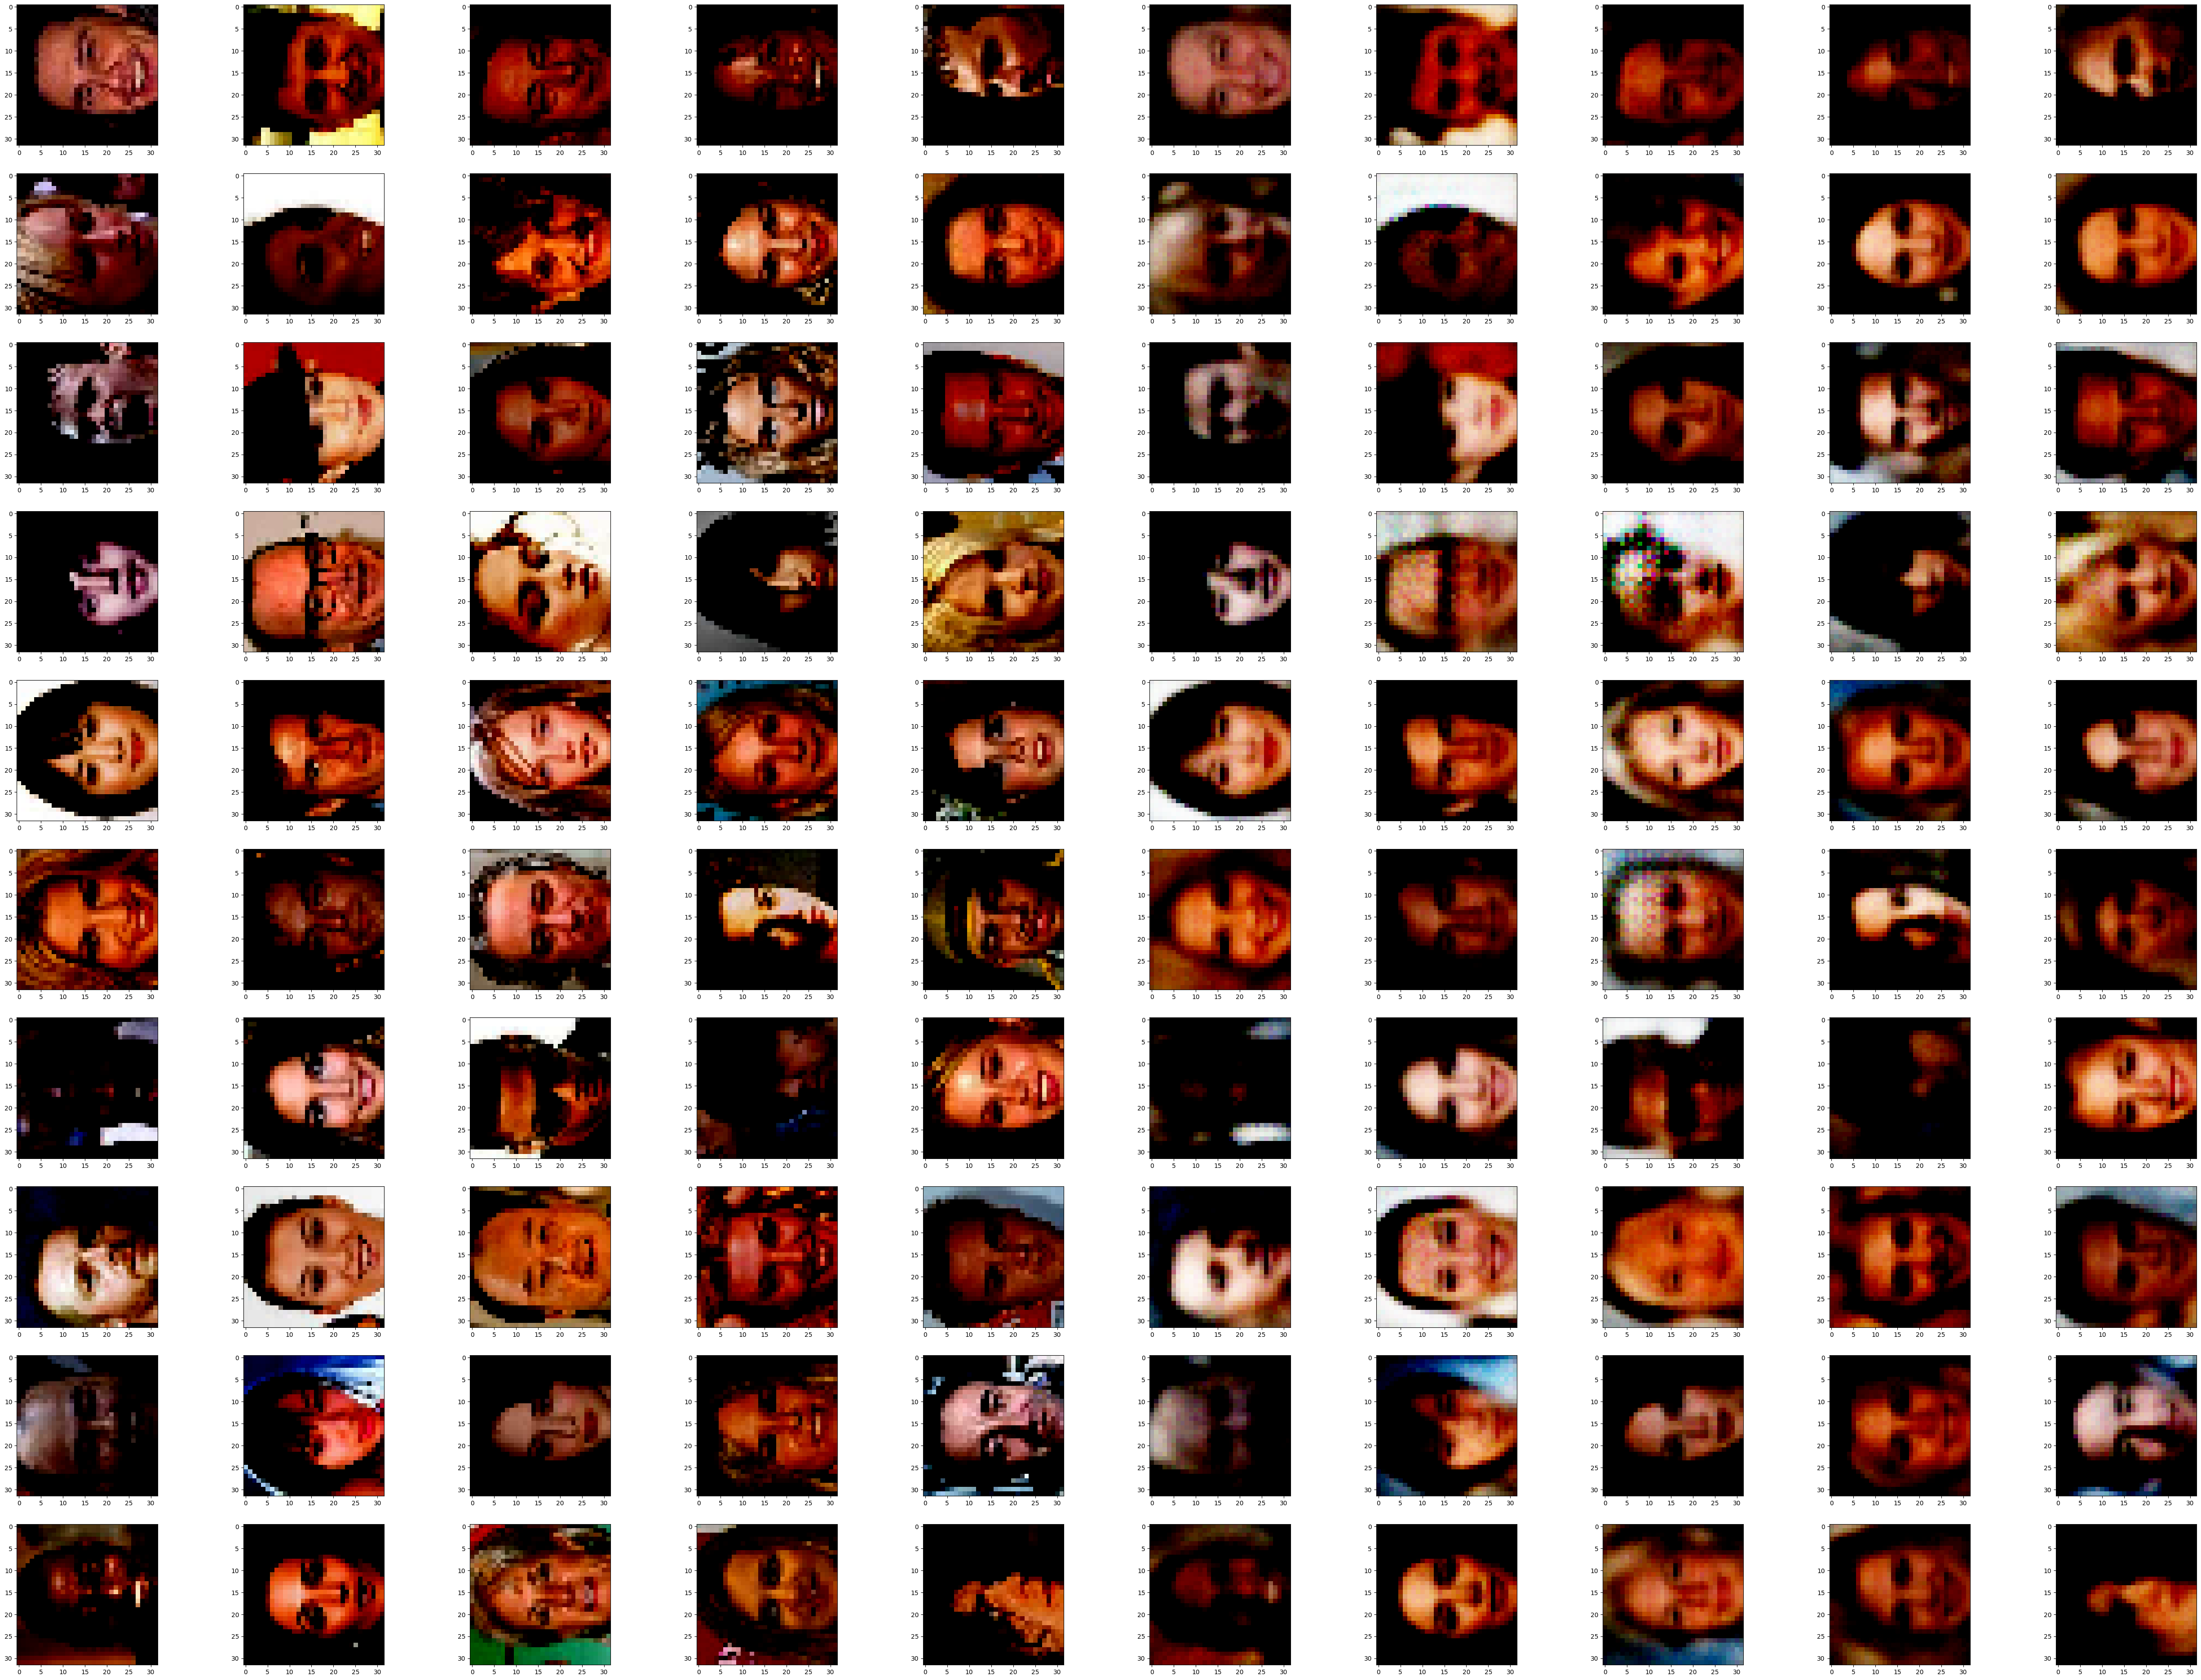

Epoch: 002/002 | Batch 0000/1582 | Loss: 98.9412
Epoch: 002/002 | Batch 0050/1582 | Loss: 88.8111
Epoch: 002/002 | Batch 0100/1582 | Loss: 97.5168
Epoch: 002/002 | Batch 0150/1582 | Loss: 98.7997
Epoch: 002/002 | Batch 0200/1582 | Loss: 96.1151
Epoch: 002/002 | Batch 0250/1582 | Loss: 94.3799
Epoch: 002/002 | Batch 0300/1582 | Loss: 85.6520
Epoch: 002/002 | Batch 0350/1582 | Loss: 96.4643
Epoch: 002/002 | Batch 0400/1582 | Loss: 88.5152
Epoch: 002/002 | Batch 0450/1582 | Loss: 91.6509
Epoch: 002/002 | Batch 0500/1582 | Loss: 85.0339
Epoch: 002/002 | Batch 0550/1582 | Loss: 89.8134
Epoch: 002/002 | Batch 0600/1582 | Loss: 88.2088
Epoch: 002/002 | Batch 0650/1582 | Loss: 85.4091
Epoch: 002/002 | Batch 0700/1582 | Loss: 94.3821
Epoch: 002/002 | Batch 0750/1582 | Loss: 86.3927
Epoch: 002/002 | Batch 0800/1582 | Loss: 81.7626
Epoch: 002/002 | Batch 0850/1582 | Loss: 76.3867
Epoch: 002/002 | Batch 0900/1582 | Loss: 83.2600
Epoch: 002/002 | Batch 0950/1582 | Loss: 83.7394
Epoch: 002/002 | Bat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

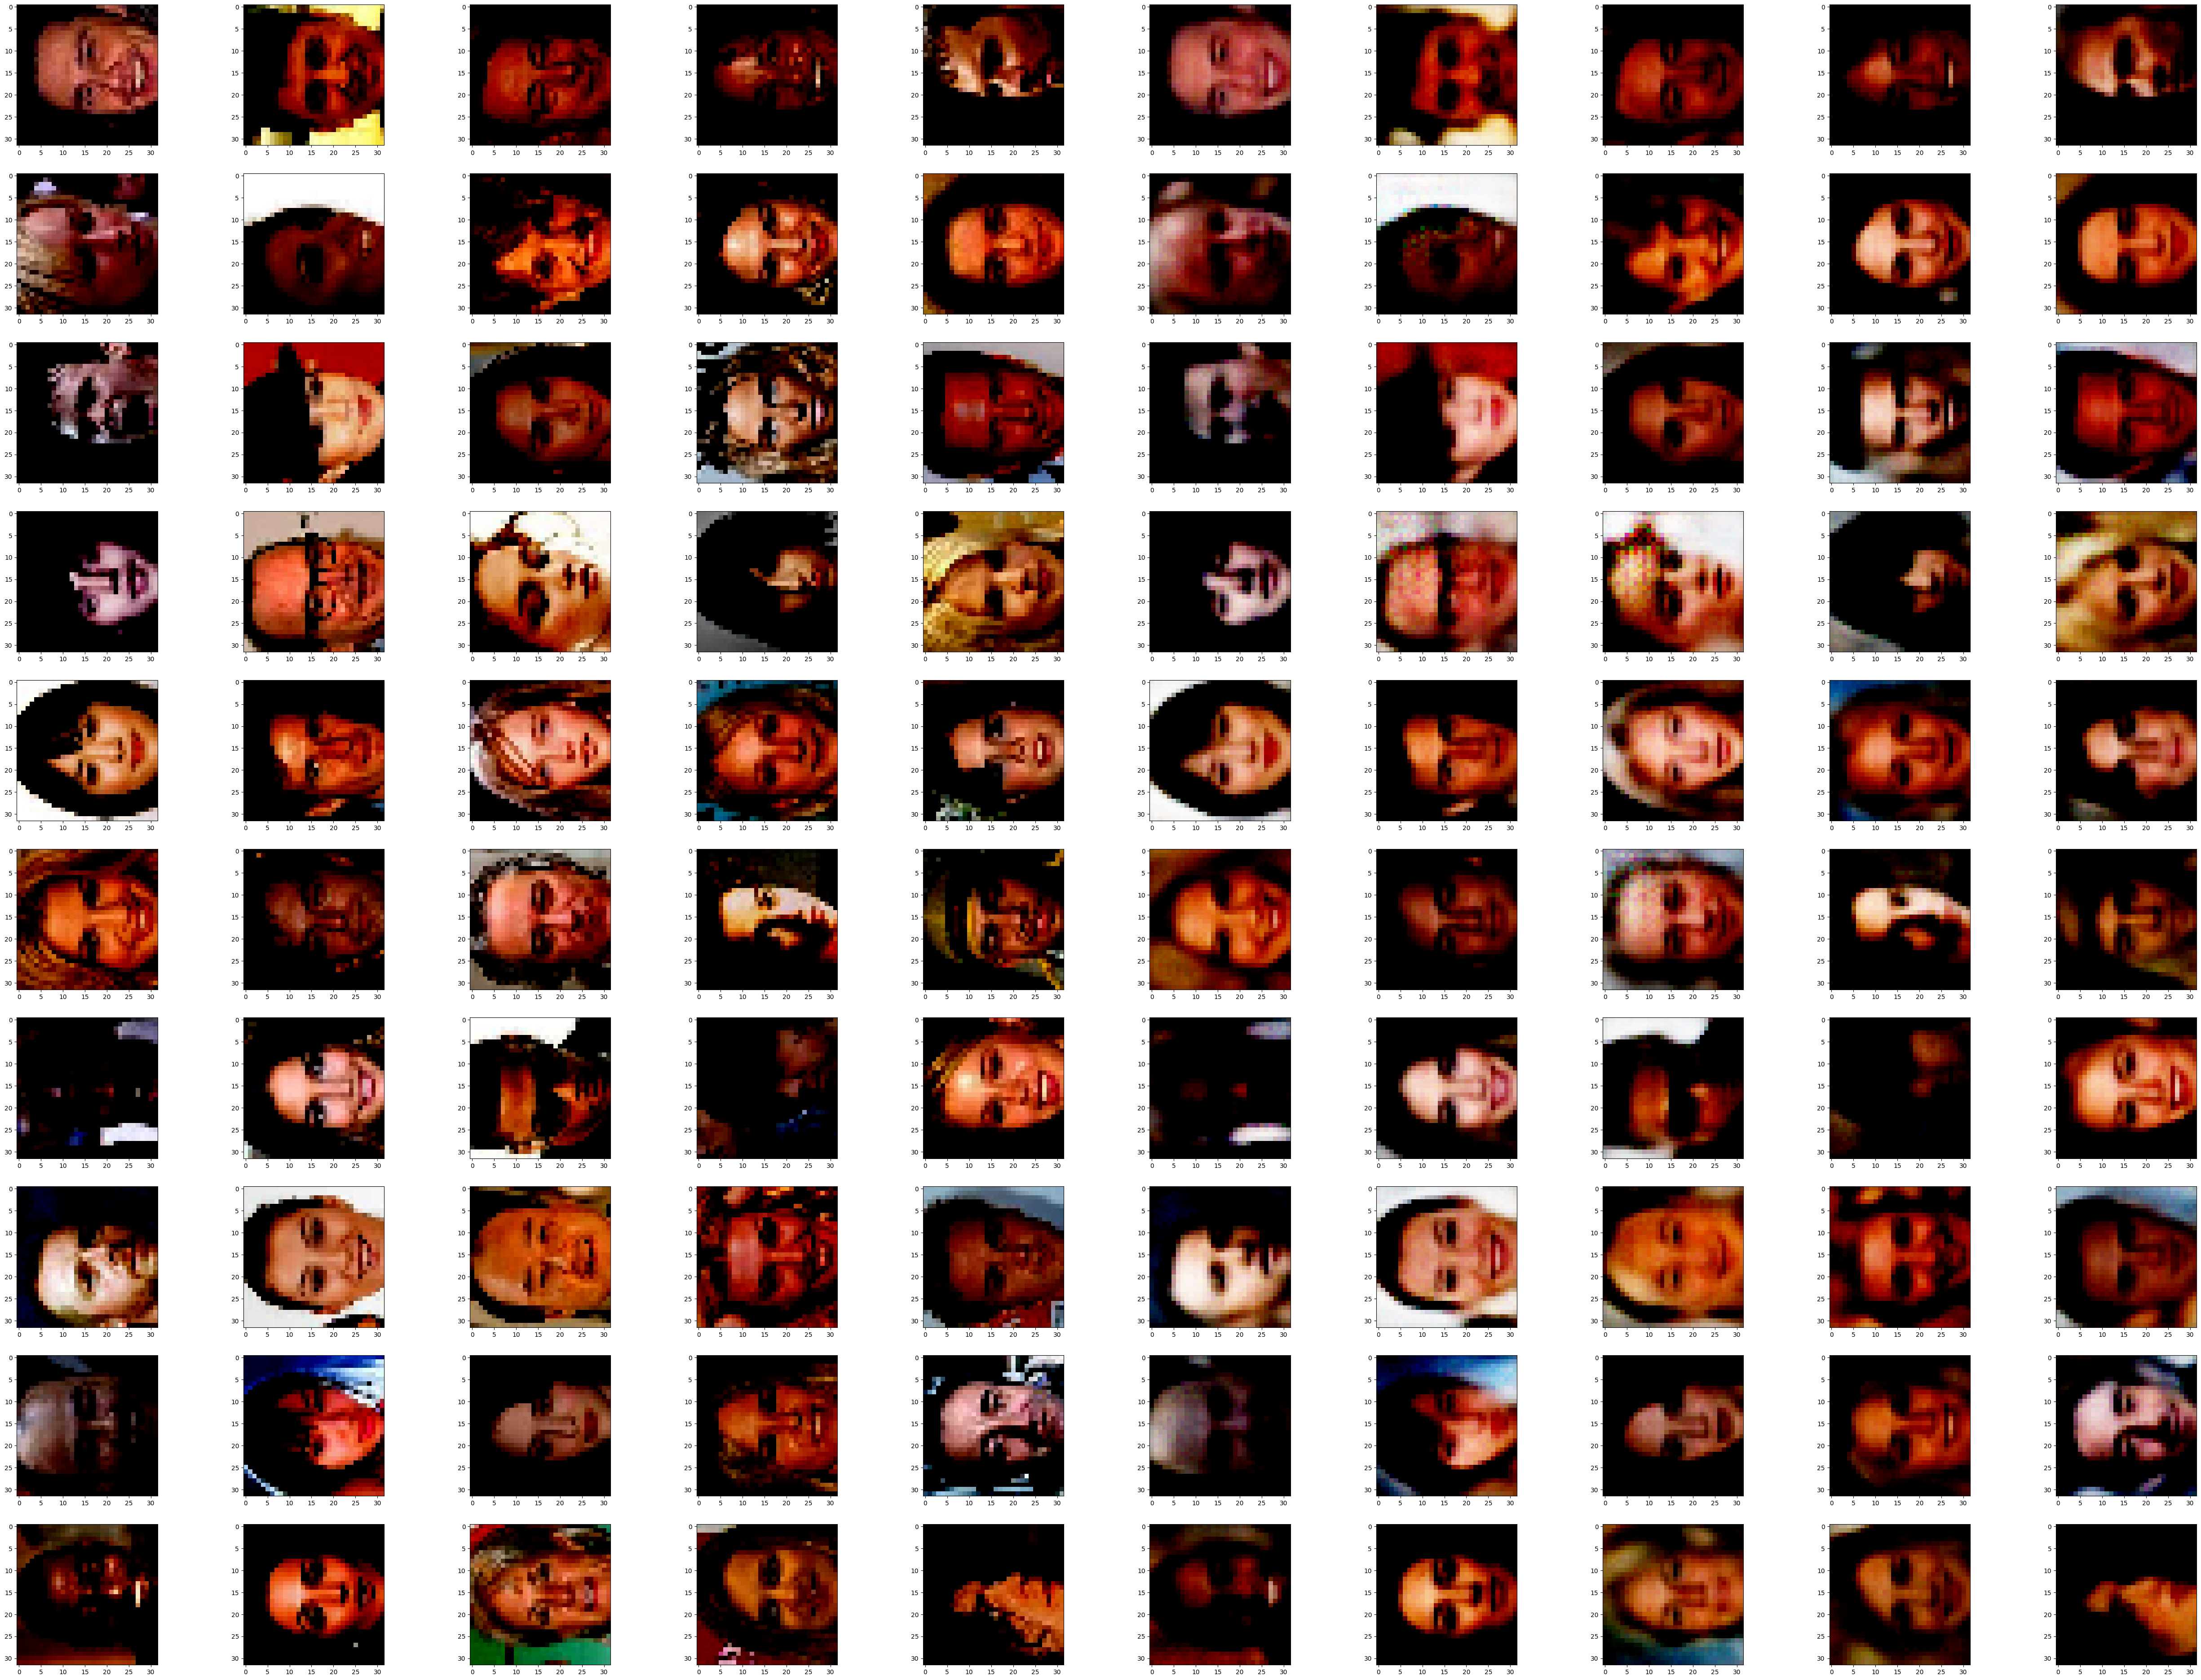

Total Training Time: 17.50 min
END OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAE


In [ ]:
torch.autograd.set_detect_anomaly(True)
NUM_EPOCHS=2
DEVICE = ['cuda:0','cuda:0']
LEARNING_RATE = 0.0001
model=VAE2().to('cuda:0')
# model.to(DEVICE)


optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 
log_dict1 = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=['cuda:0','cuda:0'], 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)
print(20*'=')
print(20*'END OF VAE')
print(20*'=')



In [ ]:
batch_size = 128
num_workers = 4

transform = transforms.Compose([transforms.ToTensor(),                                
                                transforms.Normalize(mean=[0.5], std=[0.5]),
                                transforms.Resize(size=[int(218/8), int(178/8)]),
                                transforms.CenterCrop((16,16))])

data_path = '../../googlenet-main/data/celeba'

dataset = ImageFolder(data_path, transform)
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
#                           num_workers=num_workers,
                          drop_last=True,)


Epoch: 001/001 | Batch 0000/1582 | Loss: 689.9920
Epoch: 001/001 | Batch 0050/1582 | Loss: 82.3614
Epoch: 001/001 | Batch 0100/1582 | Loss: 58.3741
Epoch: 001/001 | Batch 0150/1582 | Loss: 47.7164
Epoch: 001/001 | Batch 0200/1582 | Loss: 43.3637
Epoch: 001/001 | Batch 0250/1582 | Loss: 37.3960
Epoch: 001/001 | Batch 0300/1582 | Loss: 32.2469
Epoch: 001/001 | Batch 0350/1582 | Loss: 33.7969
Epoch: 001/001 | Batch 0400/1582 | Loss: 30.3623
Epoch: 001/001 | Batch 0450/1582 | Loss: 29.4343
Epoch: 001/001 | Batch 0500/1582 | Loss: 26.2665
Epoch: 001/001 | Batch 0550/1582 | Loss: 25.4994
Epoch: 001/001 | Batch 0600/1582 | Loss: 28.1909
Epoch: 001/001 | Batch 0650/1582 | Loss: 23.9186
Epoch: 001/001 | Batch 0700/1582 | Loss: 26.4116
Epoch: 001/001 | Batch 0750/1582 | Loss: 23.6782
Epoch: 001/001 | Batch 0800/1582 | Loss: 21.3330
Epoch: 001/001 | Batch 0850/1582 | Loss: 18.7095
Epoch: 001/001 | Batch 0900/1582 | Loss: 20.5576
Epoch: 001/001 | Batch 0950/1582 | Loss: 19.9358
Epoch: 001/001 | Ba

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

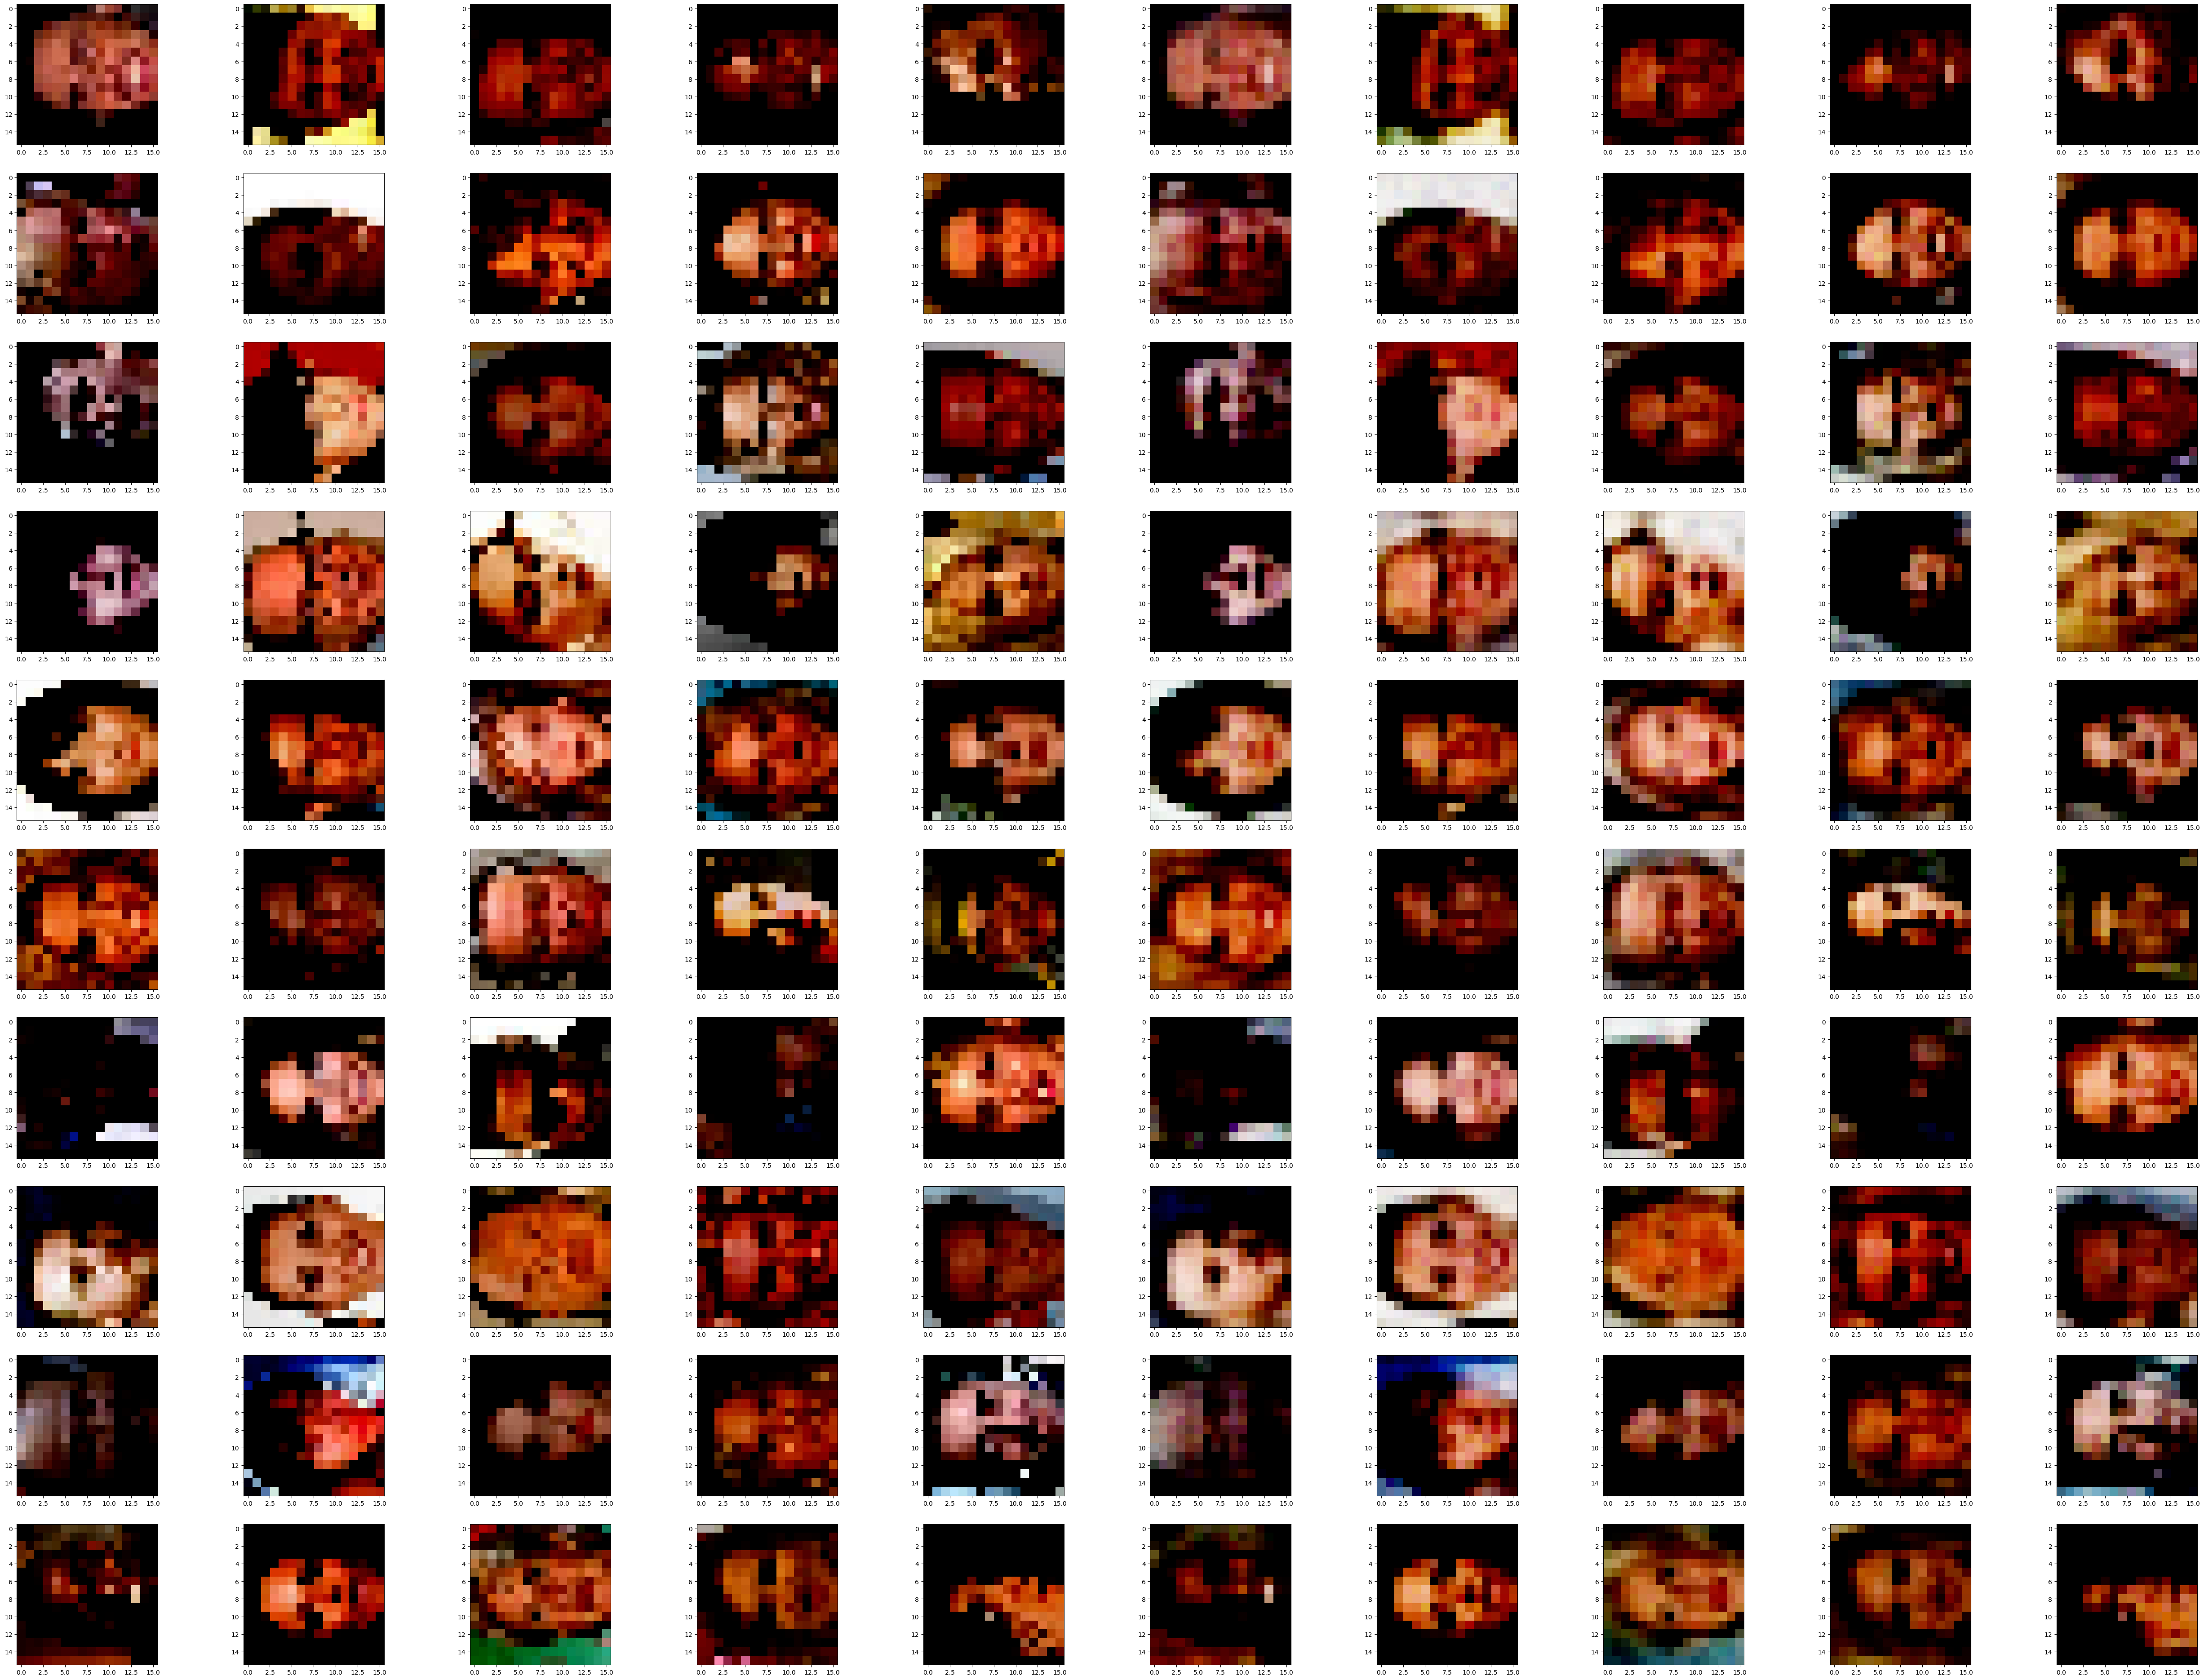

Total Training Time: 6.86 min
END OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAE


In [ ]:
torch.autograd.set_detect_anomaly(True)
NUM_EPOCHS=1
DEVICE = ['cuda:0','cuda:0']
LEARNING_RATE = 0.0001
model=VAE1().to('cuda:0')
# model.to(DEVICE)


optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 
log_dict2 = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=['cuda:0','cuda:0'], 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)
print(20*'=')
print(20*'END OF VAE')
print(20*'=')
model1=model


128

training1
Epoch: 001/001 | Batch 000/1582 | Gen/Dis Loss: 1.5576/0.7093
Epoch: 001/001 | Batch 100/1582 | Gen/Dis Loss: 4.3770/0.1713
Epoch: 001/001 | Batch 200/1582 | Gen/Dis Loss: 3.0614/0.3991
Epoch: 001/001 | Batch 300/1582 | Gen/Dis Loss: 3.1207/0.3490
Epoch: 001/001 | Batch 400/1582 | Gen/Dis Loss: 4.0381/0.4671
Epoch: 001/001 | Batch 500/1582 | Gen/Dis Loss: 1.6739/0.3773
Epoch: 001/001 | Batch 600/1582 | Gen/Dis Loss: 1.2196/0.5342
Epoch: 001/001 | Batch 700/1582 | Gen/Dis Loss: 2.2008/0.2346
Epoch: 001/001 | Batch 800/1582 | Gen/Dis Loss: 2.6261/0.3482
Epoch: 001/001 | Batch 900/1582 | Gen/Dis Loss: 2.0898/0.1431
Epoch: 001/001 | Batch 1000/1582 | Gen/Dis Loss: 4.1216/0.0548
Epoch: 001/001 | Batch 1100/1582 | Gen/Dis Loss: 3.4592/0.0603
Epoch: 001/001 | Batch 1200/1582 | Gen/Dis Loss: 8.9184/0.0267
Epoch: 001/001 | Batch 1300/1582 | Gen/Dis Loss: 7.8159/0.0120
Epoch: 001/001 | Batch 1400/1582 | Gen/Dis Loss: 5.3439/0.0103
Epoch: 001/001 | Batch 1500/1582 | Gen/Dis Loss: 3.5009

/tmp/ipykernel_7317/798421038.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.array(a).T[1].astype(np.int)
/tmp/ipykernel_7317/798421038.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; fo

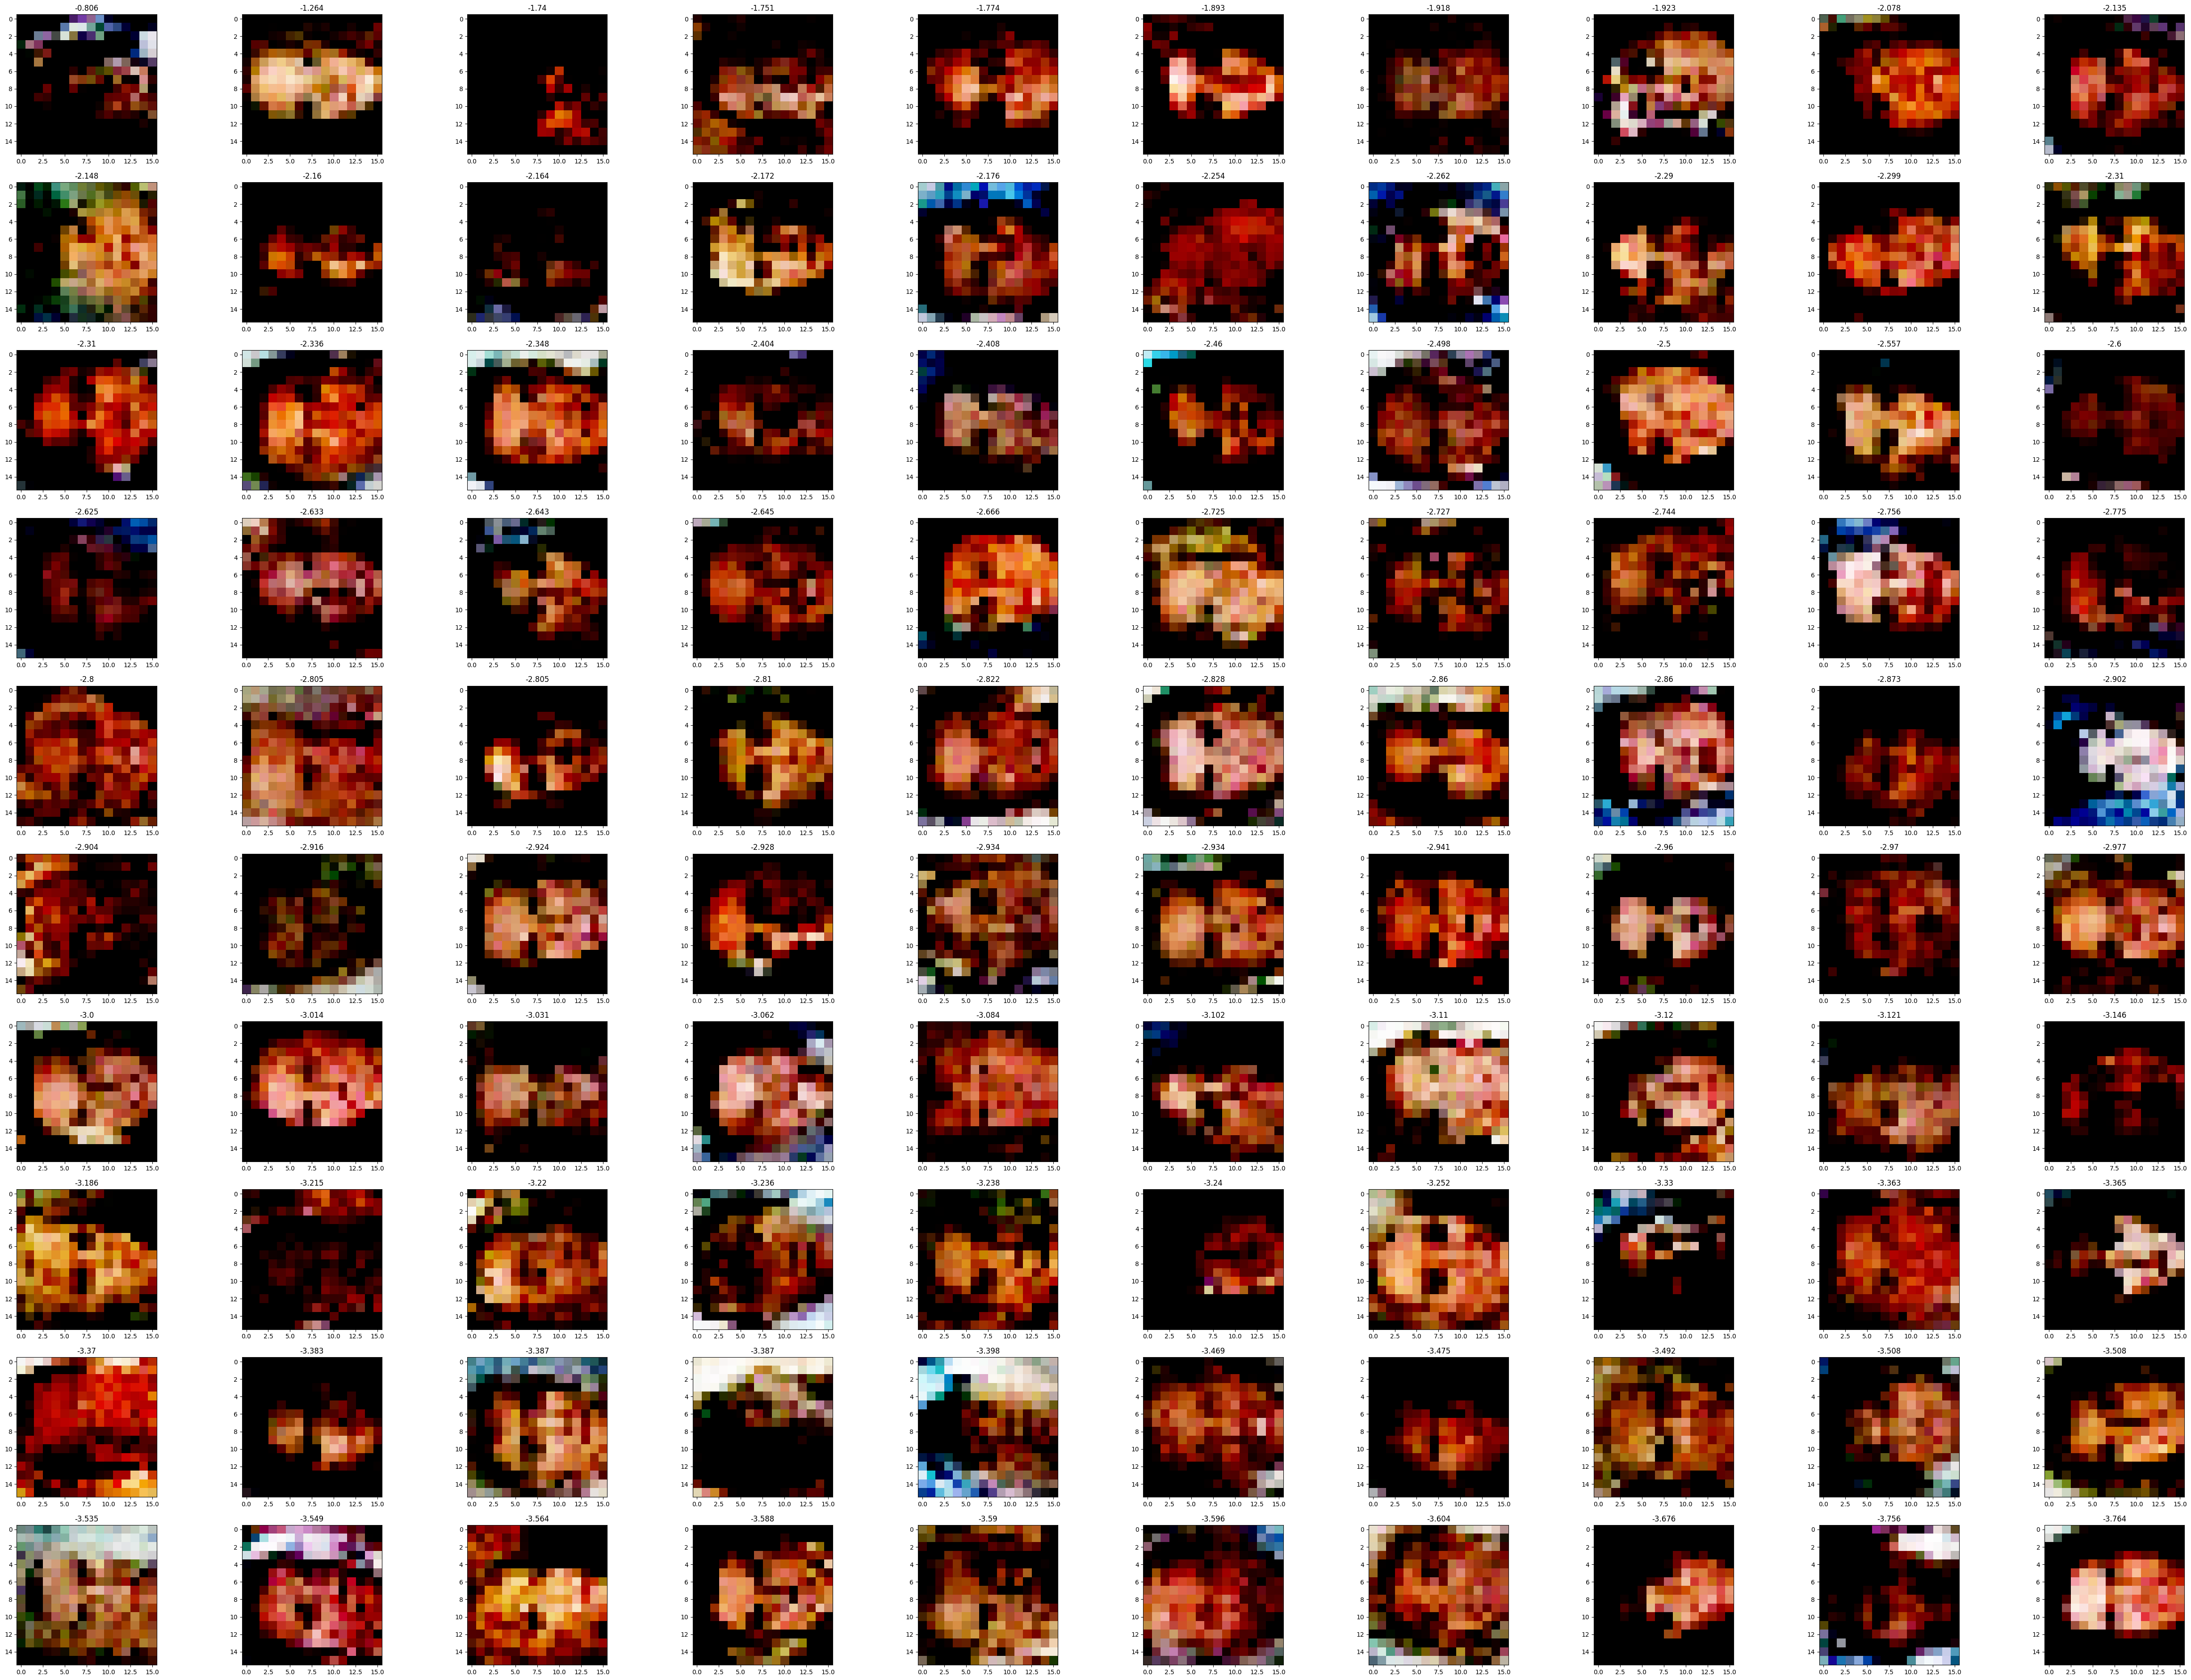

lol
Time elapsed: 8.29 min
Total Training Time: 8.29 min
END OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GAN


In [ ]:
model1 = model
model = DCGAN1()
model.to('cpu')
model.discriminator1 = model1.discriminator1
model.generator1 = model1.generator1
model.to('cuda:0')

log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
#                         optimizer_gen=o ptim_gen,
#                         optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_celeba_01.pt')
                        
d1 = model.to('cpu')
print(20*'=')
print(20*'END OF GAN')
print(20*'=')
# model1.to('cpu')
# model.discriminator1 = model1.discriminator1
# model.to('cuda:0')
# log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
#                         optimizer=optimizer, device=['cuda:0','cuda:0'], 
#                         train_loader=train_loader,
#                         skip_epoch_stats=True,
#                         logging_interval=50)


training1
Epoch: 001/001 | Batch 000/1582 | Gen/Dis Loss: 1.8749/0.6410
Epoch: 001/001 | Batch 100/1582 | Gen/Dis Loss: 6.0067/0.2764
Epoch: 001/001 | Batch 200/1582 | Gen/Dis Loss: 3.0438/0.4198
Epoch: 001/001 | Batch 300/1582 | Gen/Dis Loss: 2.4211/0.4741
Epoch: 001/001 | Batch 400/1582 | Gen/Dis Loss: 1.4391/0.4472
Epoch: 001/001 | Batch 500/1582 | Gen/Dis Loss: 1.9519/0.4391
Epoch: 001/001 | Batch 600/1582 | Gen/Dis Loss: 2.5818/0.4461
Epoch: 001/001 | Batch 700/1582 | Gen/Dis Loss: 1.5225/0.4123
Epoch: 001/001 | Batch 800/1582 | Gen/Dis Loss: 1.8503/0.3105
Epoch: 001/001 | Batch 900/1582 | Gen/Dis Loss: 1.5520/0.1873
Epoch: 001/001 | Batch 1000/1582 | Gen/Dis Loss: 7.3702/0.0287
Epoch: 001/001 | Batch 1100/1582 | Gen/Dis Loss: 6.5291/0.0135
Epoch: 001/001 | Batch 1200/1582 | Gen/Dis Loss: 7.9633/0.0187
Epoch: 001/001 | Batch 1300/1582 | Gen/Dis Loss: 3.8278/0.1372
Epoch: 001/001 | Batch 1400/1582 | Gen/Dis Loss: 6.6372/0.4927
Epoch: 001/001 | Batch 1500/1582 | Gen/Dis Loss: 8.0387

/tmp/ipykernel_7317/798421038.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.array(a).T[1].astype(np.int)
/tmp/ipykernel_7317/798421038.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; fo

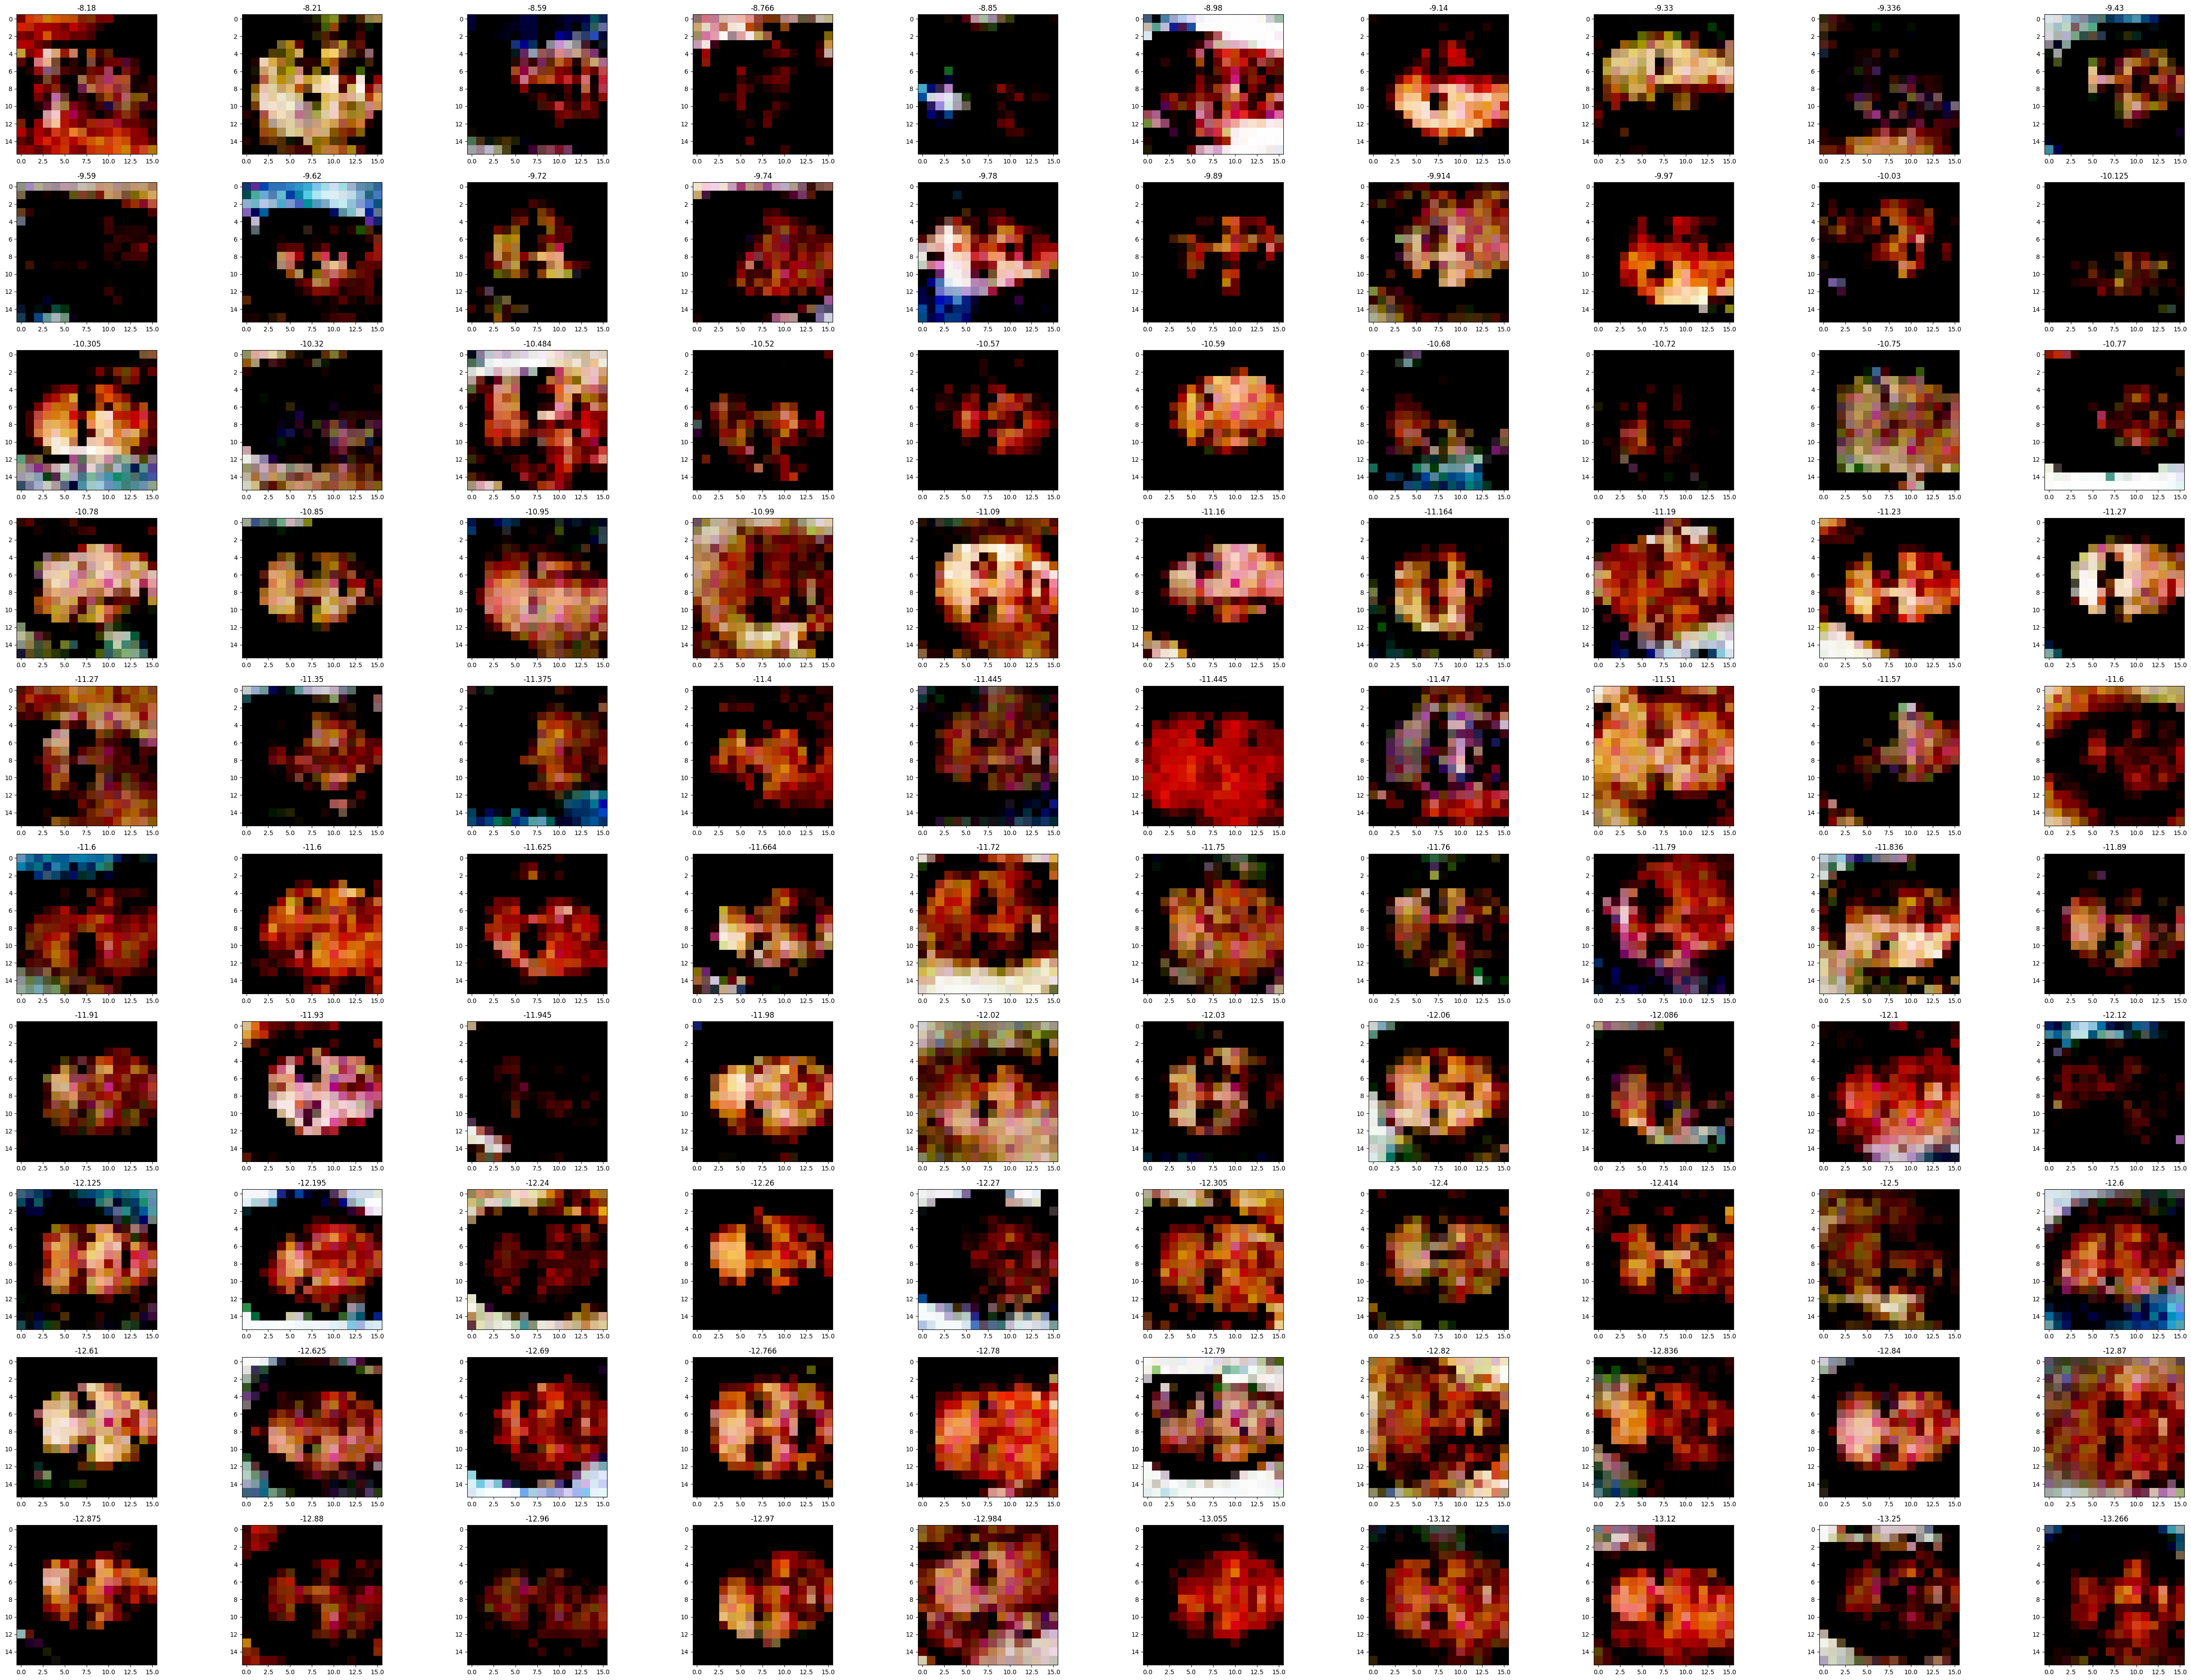

lol
Time elapsed: 8.09 min
Total Training Time: 8.09 min
END OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GAN


In [ ]:
model = DCGAN1()
model.to('cuda:0')
model.generator1 = model1.generator1
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
#                         optimizer_gen=o ptim_gen,
#                         optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_celeba_01.pt')
                        
d2 = model.to('cpu')

print(20*'=')
print(20*'END OF GAN')
print(20*'=')
# model1.to('cpu')
# model.discriminator1 = model1.discriminator1
# model.to('cuda:0')
# log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
#                         optimizer=optimizer, device=['cuda:0','cuda:0'], 
#                         train_loader=train_loader,
#                         skip_epoch_stats=True,
#                         logging_interval=50)


training1
Epoch: 001/001 | Batch 000/1582 | Gen/Dis Loss: 1.5240/0.7152
Epoch: 001/001 | Batch 100/1582 | Gen/Dis Loss: 6.5814/0.2069
Epoch: 001/001 | Batch 200/1582 | Gen/Dis Loss: 6.4813/0.0101
Epoch: 001/001 | Batch 300/1582 | Gen/Dis Loss: 3.8249/0.5211
Epoch: 001/001 | Batch 400/1582 | Gen/Dis Loss: 2.5834/0.2896
Epoch: 001/001 | Batch 500/1582 | Gen/Dis Loss: 2.4058/0.3525
Epoch: 001/001 | Batch 600/1582 | Gen/Dis Loss: 1.6144/0.2830
Epoch: 001/001 | Batch 700/1582 | Gen/Dis Loss: 2.4541/0.2294
Epoch: 001/001 | Batch 800/1582 | Gen/Dis Loss: 4.6054/0.1032
Epoch: 001/001 | Batch 900/1582 | Gen/Dis Loss: 4.4964/0.3889
Epoch: 001/001 | Batch 1000/1582 | Gen/Dis Loss: 4.7217/0.8673
Epoch: 001/001 | Batch 1100/1582 | Gen/Dis Loss: 3.5597/0.0311
Epoch: 001/001 | Batch 1200/1582 | Gen/Dis Loss: 11.1639/0.0035
Epoch: 001/001 | Batch 1300/1582 | Gen/Dis Loss: 8.9109/0.0067
Epoch: 001/001 | Batch 1400/1582 | Gen/Dis Loss: 7.6242/0.0782
Epoch: 001/001 | Batch 1500/1582 | Gen/Dis Loss: 8.583

/tmp/ipykernel_7317/798421038.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.array(a).T[1].astype(np.int)
/tmp/ipykernel_7317/798421038.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; fo

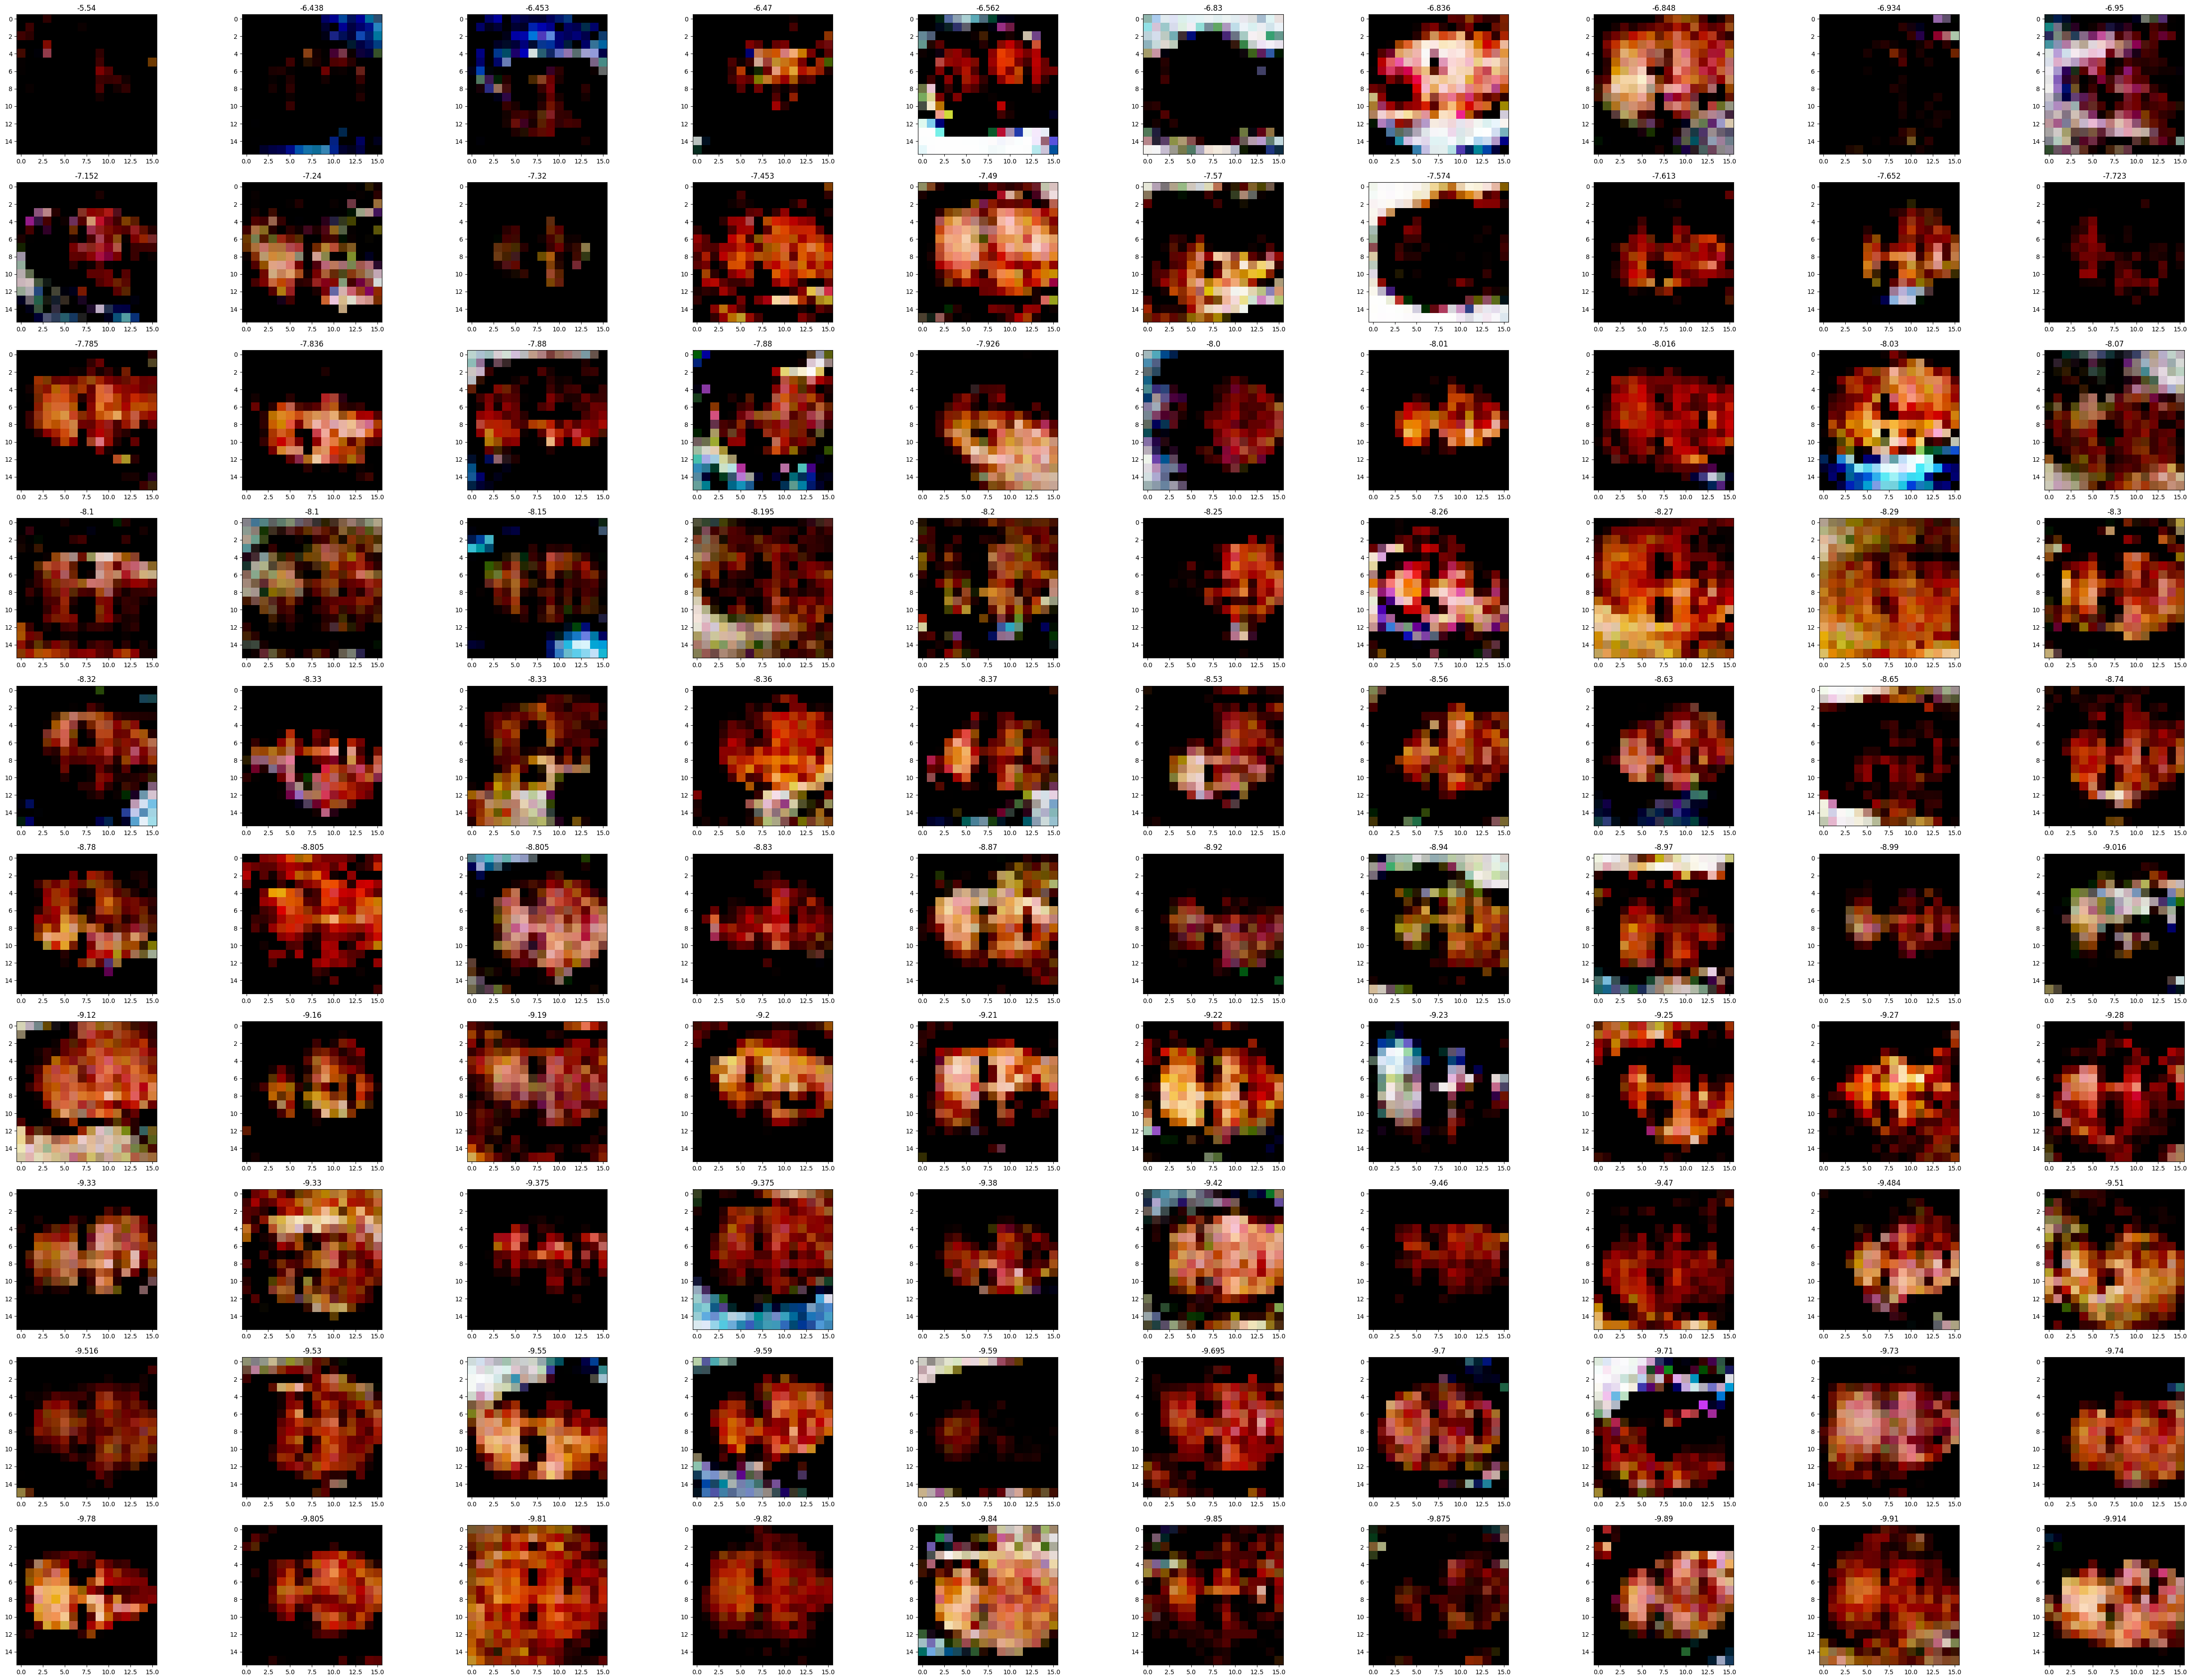

lol
Time elapsed: 8.31 min
Total Training Time: 8.31 min
END OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GAN


In [ ]:
model = DCGAN1()
model.to('cuda:0')
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
#                         optimizer_gen=o ptim_gen,
#                         optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_celeba_01.pt')

d3 = model.to('cpu')
                        
print(20*'=')
print(20*'END OF GAN')
print(20*'=')
# model1.to('cpu')
# model.discriminator1 = model1.discriminator1
# model.to('cuda:0')
# log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
#                         optimizer=optimizer, device=['cuda:0','cuda:0'], 
#                         train_loader=train_loader,
#                         skip_epoch_stats=True,
#                         logging_interval=50)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

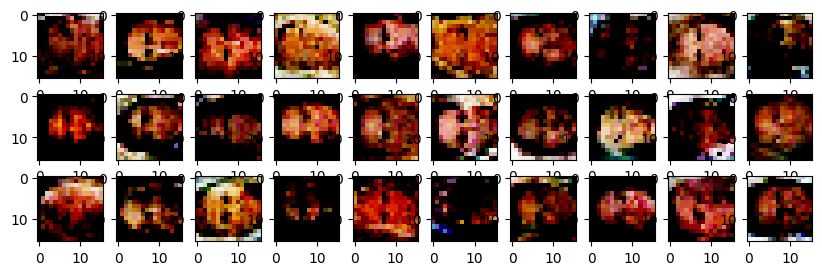

In [ ]:
fig, ax = plt.subplots(3,10, figsize=(10,3))
r = torch.randn(10,100,1,1)
img = d1.generator(r).detach().cpu().numpy()
img.astype(int)
for i in range(10): 
    ax[0,i].imshow(img[i].T)
img = d2.generator(r).detach().cpu().numpy()
img.astype(int)
for i in range(10):
    ax[1,i].imshow(img[i].T) 
img = d3.generator(r).detach().cpu().numpy()
img.astype(int)
for i in range(10):
    ax[2,i].imshow(img[i].T) 


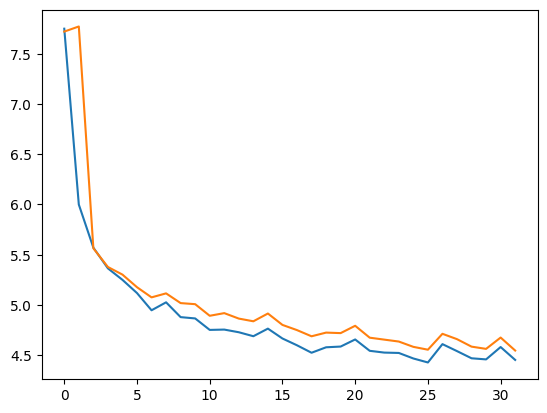

In [ ]:
l1 = [2324.4429,403.2629,262.5080,213.5335,190.4486,166.9656,140.6425,152.2487,131.3695,129.6637,115.6661,116.0421,112.9965,108.6153,117.1549,106.1849,99.2346,92.1339,97.2743,97.9872,105.1659,93.9203,92.2732,91.9387,87.0126,83.6185,100.3863,93.6376,87.1860,86.2272,97.5111,85.7780]
l2 = [2258.5408,2376.2552,260.7901,216.4777,200.6696,176.9970,159.9528,166.4468,151.0760,149.4525,133.1486,136.7063,129.4722,126.0376,136.1812,121.5699,115.4342,108.5439,112.6042,112.0330,120.5186,107.0338,104.9980,103.0034,97.7001,94.9685,111.2518,105.4870,97.9134,95.7497,107.1857,94.1740]
plt.plot(np.arange(len(l1)), np.log(np.array(l1)))
plt.plot(np.arange(len(l1)), np.log(np.array(l2)))

Epoch: 001/001 | Batch 0000/1582 | Loss: 647.5027
Epoch: 001/001 | Batch 0050/1582 | Loss: 77.9029
Epoch: 001/001 | Batch 0100/1582 | Loss: 55.3523
Epoch: 001/001 | Batch 0150/1582 | Loss: 45.8557
Epoch: 001/001 | Batch 0200/1582 | Loss: 40.9724
Epoch: 001/001 | Batch 0250/1582 | Loss: 37.3370
Epoch: 001/001 | Batch 0300/1582 | Loss: 31.4200
Epoch: 001/001 | Batch 0350/1582 | Loss: 33.9033
Epoch: 001/001 | Batch 0400/1582 | Loss: 30.1434
Epoch: 001/001 | Batch 0450/1582 | Loss: 29.1973
Epoch: 001/001 | Batch 0500/1582 | Loss: 25.4786
Epoch: 001/001 | Batch 0550/1582 | Loss: 25.1031
Epoch: 001/001 | Batch 0600/1582 | Loss: 28.1849
Epoch: 001/001 | Batch 0650/1582 | Loss: 23.4677
Epoch: 001/001 | Batch 0700/1582 | Loss: 25.4145
Epoch: 001/001 | Batch 0750/1582 | Loss: 23.4183
Epoch: 001/001 | Batch 0800/1582 | Loss: 21.1569
Epoch: 001/001 | Batch 0850/1582 | Loss: 18.2890
Epoch: 001/001 | Batch 0900/1582 | Loss: 20.8171
Epoch: 001/001 | Batch 0950/1582 | Loss: 19.8545
Epoch: 001/001 | Ba

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

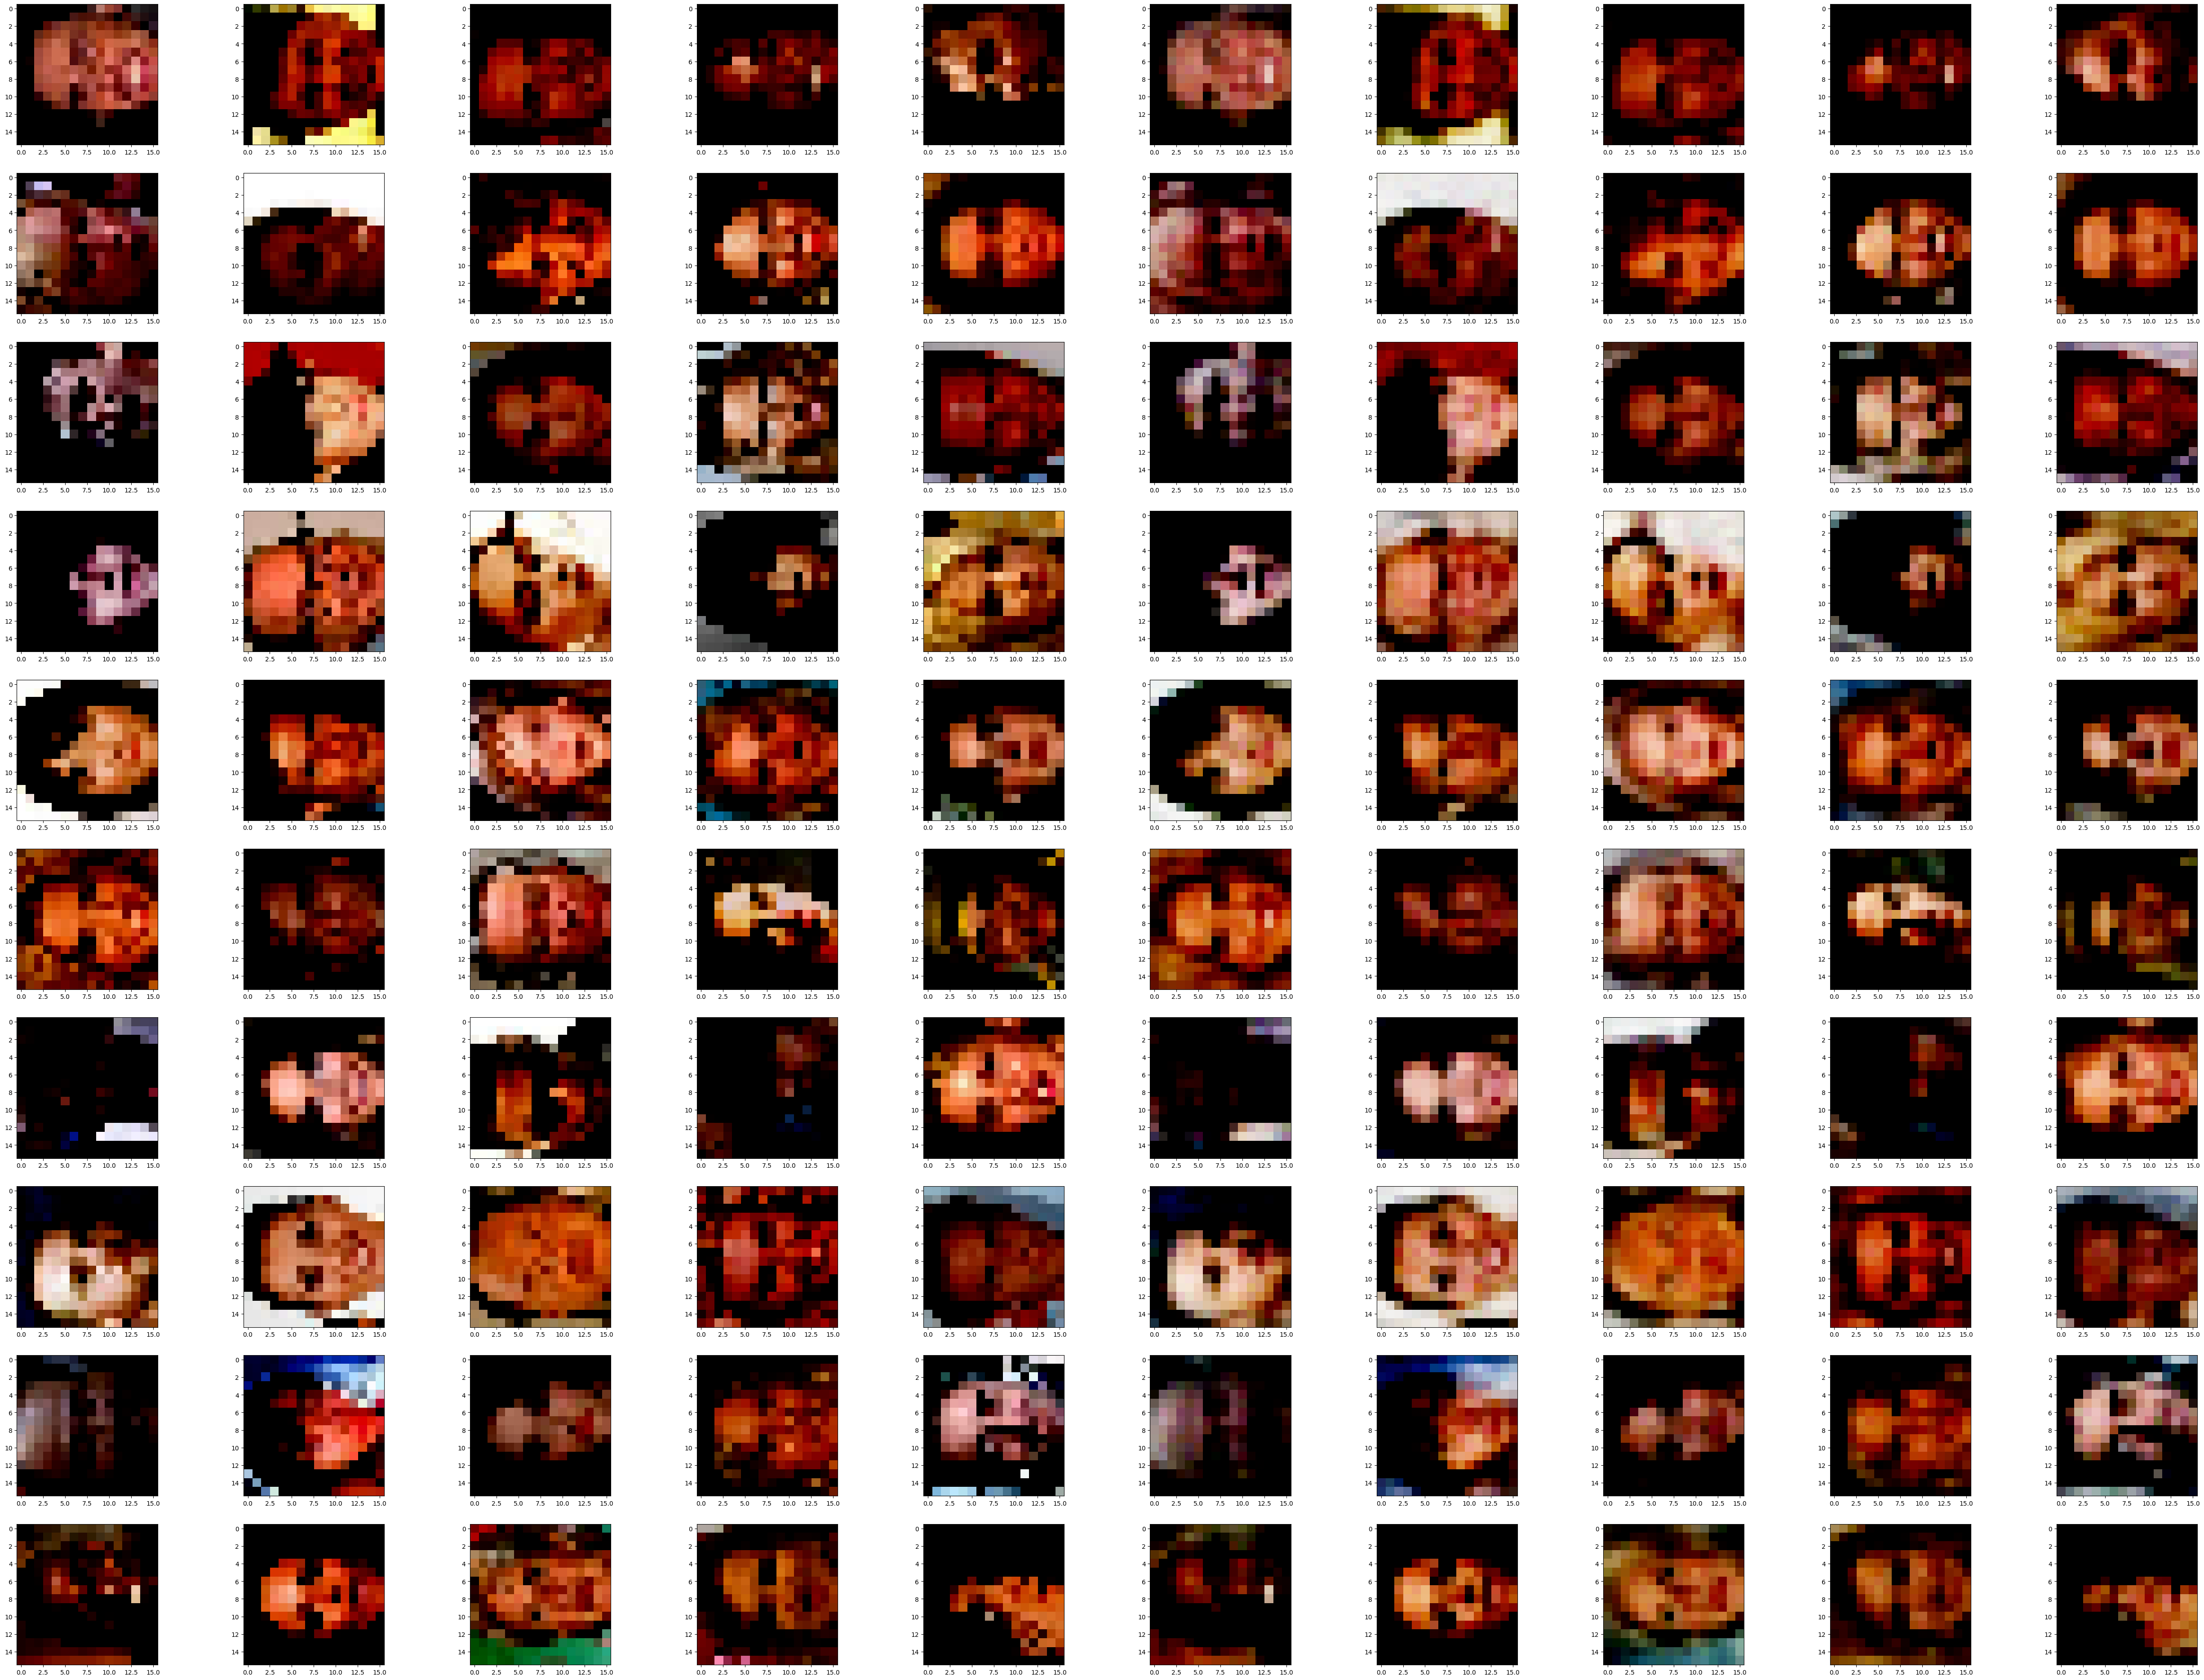

Total Training Time: 7.50 min
END OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAE


In [ ]:
torch.autograd.set_detect_anomaly(True)
NUM_EPOCHS=1
DEVICE = ['cuda:0','cuda:0']
LEARNING_RATE = 0.0001
model=VAE1().to('cuda:0')
# model.to(DEVICE)


optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 
log_dict2 = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=['cuda:0','cuda:0'], 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)
print(20*'=')
print(20*'END OF VAE')
print(20*'=')
model1=model


training1
Epoch: 001/001 | Batch 000/1582 | Gen/Dis Loss: 1.5804/0.7254
Epoch: 001/001 | Batch 100/1582 | Gen/Dis Loss: 5.3418/0.1581
Epoch: 001/001 | Batch 200/1582 | Gen/Dis Loss: 2.8233/0.5149
Epoch: 001/001 | Batch 300/1582 | Gen/Dis Loss: 2.0097/0.4161
Epoch: 001/001 | Batch 400/1582 | Gen/Dis Loss: 2.3963/0.3473
Epoch: 001/001 | Batch 500/1582 | Gen/Dis Loss: 2.1095/0.3865
Epoch: 001/001 | Batch 600/1582 | Gen/Dis Loss: 3.2418/0.6021
Epoch: 001/001 | Batch 700/1582 | Gen/Dis Loss: 2.6234/0.5255
Epoch: 001/001 | Batch 800/1582 | Gen/Dis Loss: 2.8357/0.5452
Epoch: 001/001 | Batch 900/1582 | Gen/Dis Loss: 5.6288/0.6625
Epoch: 001/001 | Batch 1000/1582 | Gen/Dis Loss: 3.5192/0.1055
Epoch: 001/001 | Batch 1100/1582 | Gen/Dis Loss: 3.2308/0.1254
Epoch: 001/001 | Batch 1200/1582 | Gen/Dis Loss: 6.0903/0.0120
Epoch: 001/001 | Batch 1300/1582 | Gen/Dis Loss: 2.8562/0.0683
Epoch: 001/001 | Batch 1400/1582 | Gen/Dis Loss: 5.1565/1.3717
Epoch: 001/001 | Batch 1500/1582 | Gen/Dis Loss: 5.0121

/tmp/ipykernel_7317/798421038.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.array(a).T[1].astype(np.int)
/tmp/ipykernel_7317/798421038.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; fo

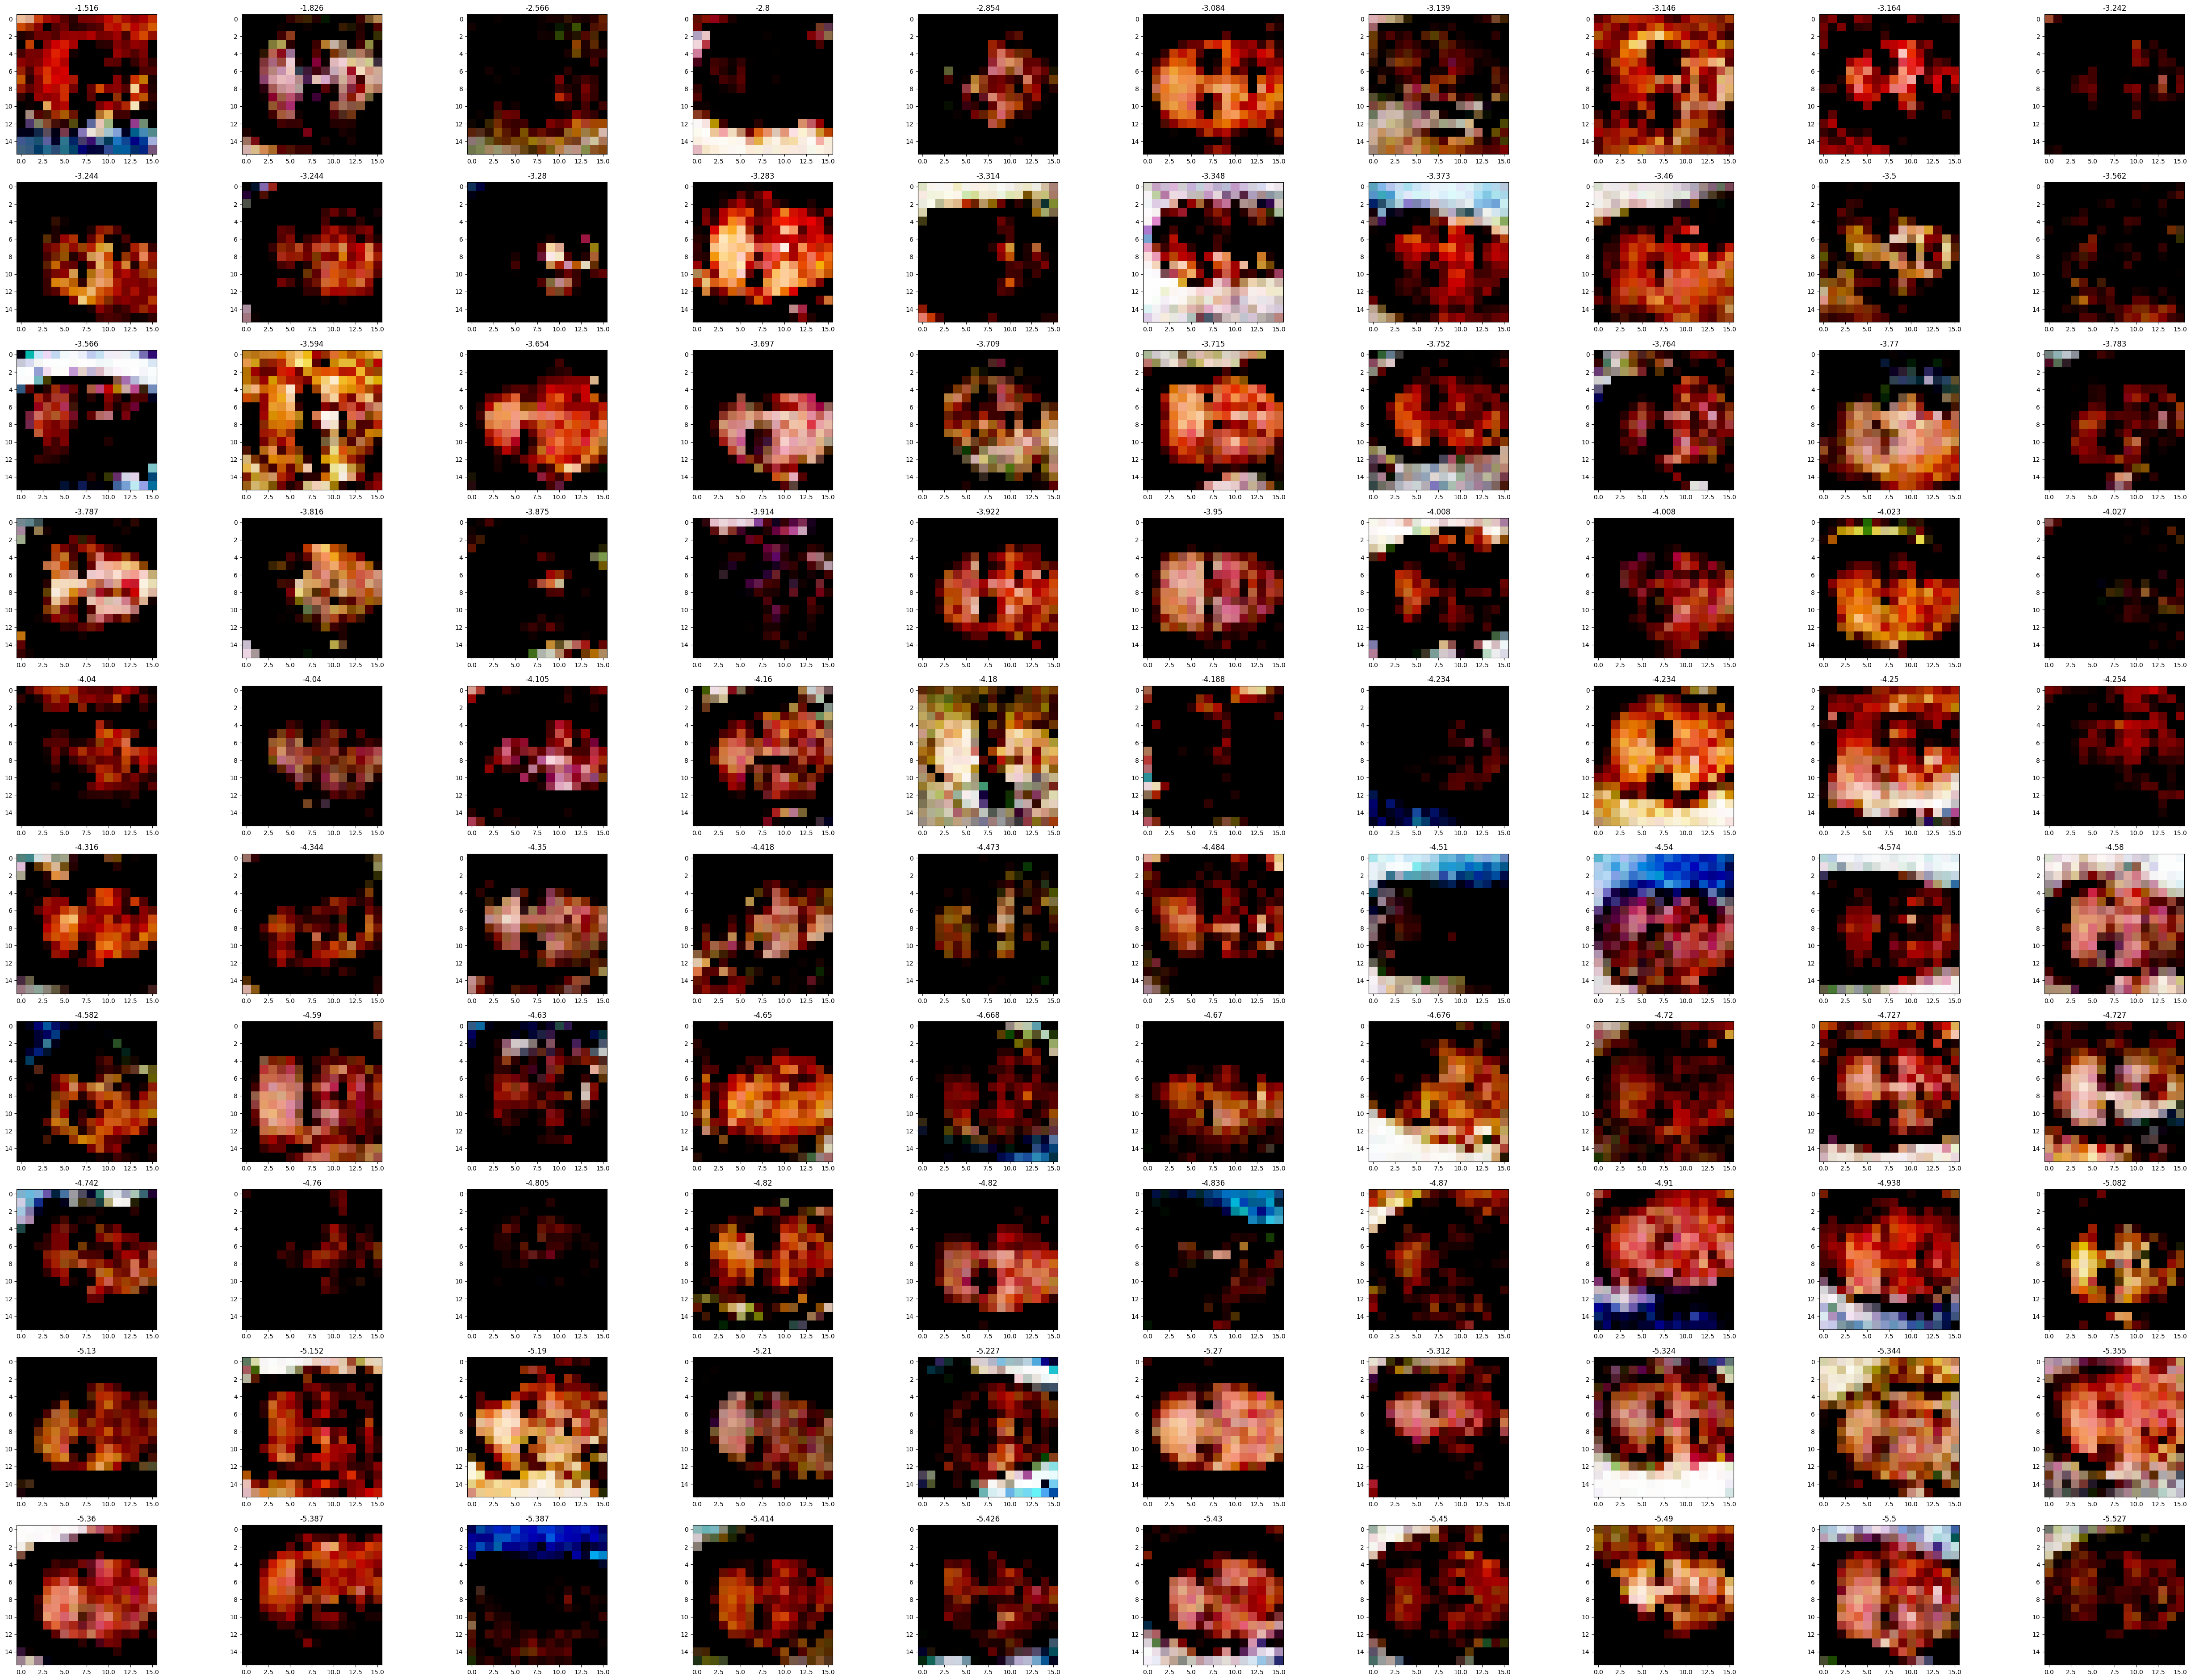

lol
Time elapsed: 8.39 min
Total Training Time: 8.39 min
END OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GANEND OF GAN


In [ ]:
model1 = model
model = DCGAN1()
model.to('cpu')
# model.discriminator1 = model1.discriminator1
model.generator1 = model1.generator1
model.to('cuda:0')

log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
#                         optimizer_gen=o ptim_gen,
#                         optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_celeba_01.pt')
                        
d1 = model.to('cpu')
print(20*'=')
print(20*'END OF GAN')
print(20*'=')
# model1.to('cpu')
# model.discriminator1 = model1.discriminator1
# model.to('cuda:0')
# log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
#                         optimizer=optimizer, device=['cuda:0','cuda:0'], 
#                         train_loader=train_loader,
#                         skip_epoch_stats=True,
#                         logging_interval=50)


In [ ]:
model2

DCGAN1(
  (generator1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (discriminator1): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01,

training1
Epoch: 001/002 | Batch 000/1582 | Gen/Dis Loss: 2.3674/0.7103
Epoch: 001/002 | Batch 050/1582 | Gen/Dis Loss: 194.5915/0.0098
Epoch: 001/002 | Batch 100/1582 | Gen/Dis Loss: 187.4825/0.0048
Epoch: 001/002 | Batch 150/1582 | Gen/Dis Loss: 7.6442/0.0022
Epoch: 001/002 | Batch 200/1582 | Gen/Dis Loss: 170.0562/0.0018
Epoch: 001/002 | Batch 250/1582 | Gen/Dis Loss: 175.3159/0.0011
Epoch: 001/002 | Batch 300/1582 | Gen/Dis Loss: 8.1166/0.0007
Epoch: 001/002 | Batch 350/1582 | Gen/Dis Loss: 133.1169/0.0017
Epoch: 001/002 | Batch 400/1582 | Gen/Dis Loss: 124.5029/0.0013
Epoch: 001/002 | Batch 450/1582 | Gen/Dis Loss: 7.7143/0.0008
Epoch: 001/002 | Batch 500/1582 | Gen/Dis Loss: 135.0090/0.0008
Epoch: 001/002 | Batch 550/1582 | Gen/Dis Loss: 127.1899/0.0017
Epoch: 001/002 | Batch 600/1582 | Gen/Dis Loss: 7.8982/0.0014
Epoch: 001/002 | Batch 650/1582 | Gen/Dis Loss: 106.9885/0.0005
Epoch: 001/002 | Batch 700/1582 | Gen/Dis Loss: 111.8195/0.0006
Epoch: 001/002 | Batch 750/1582 | Gen/Di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

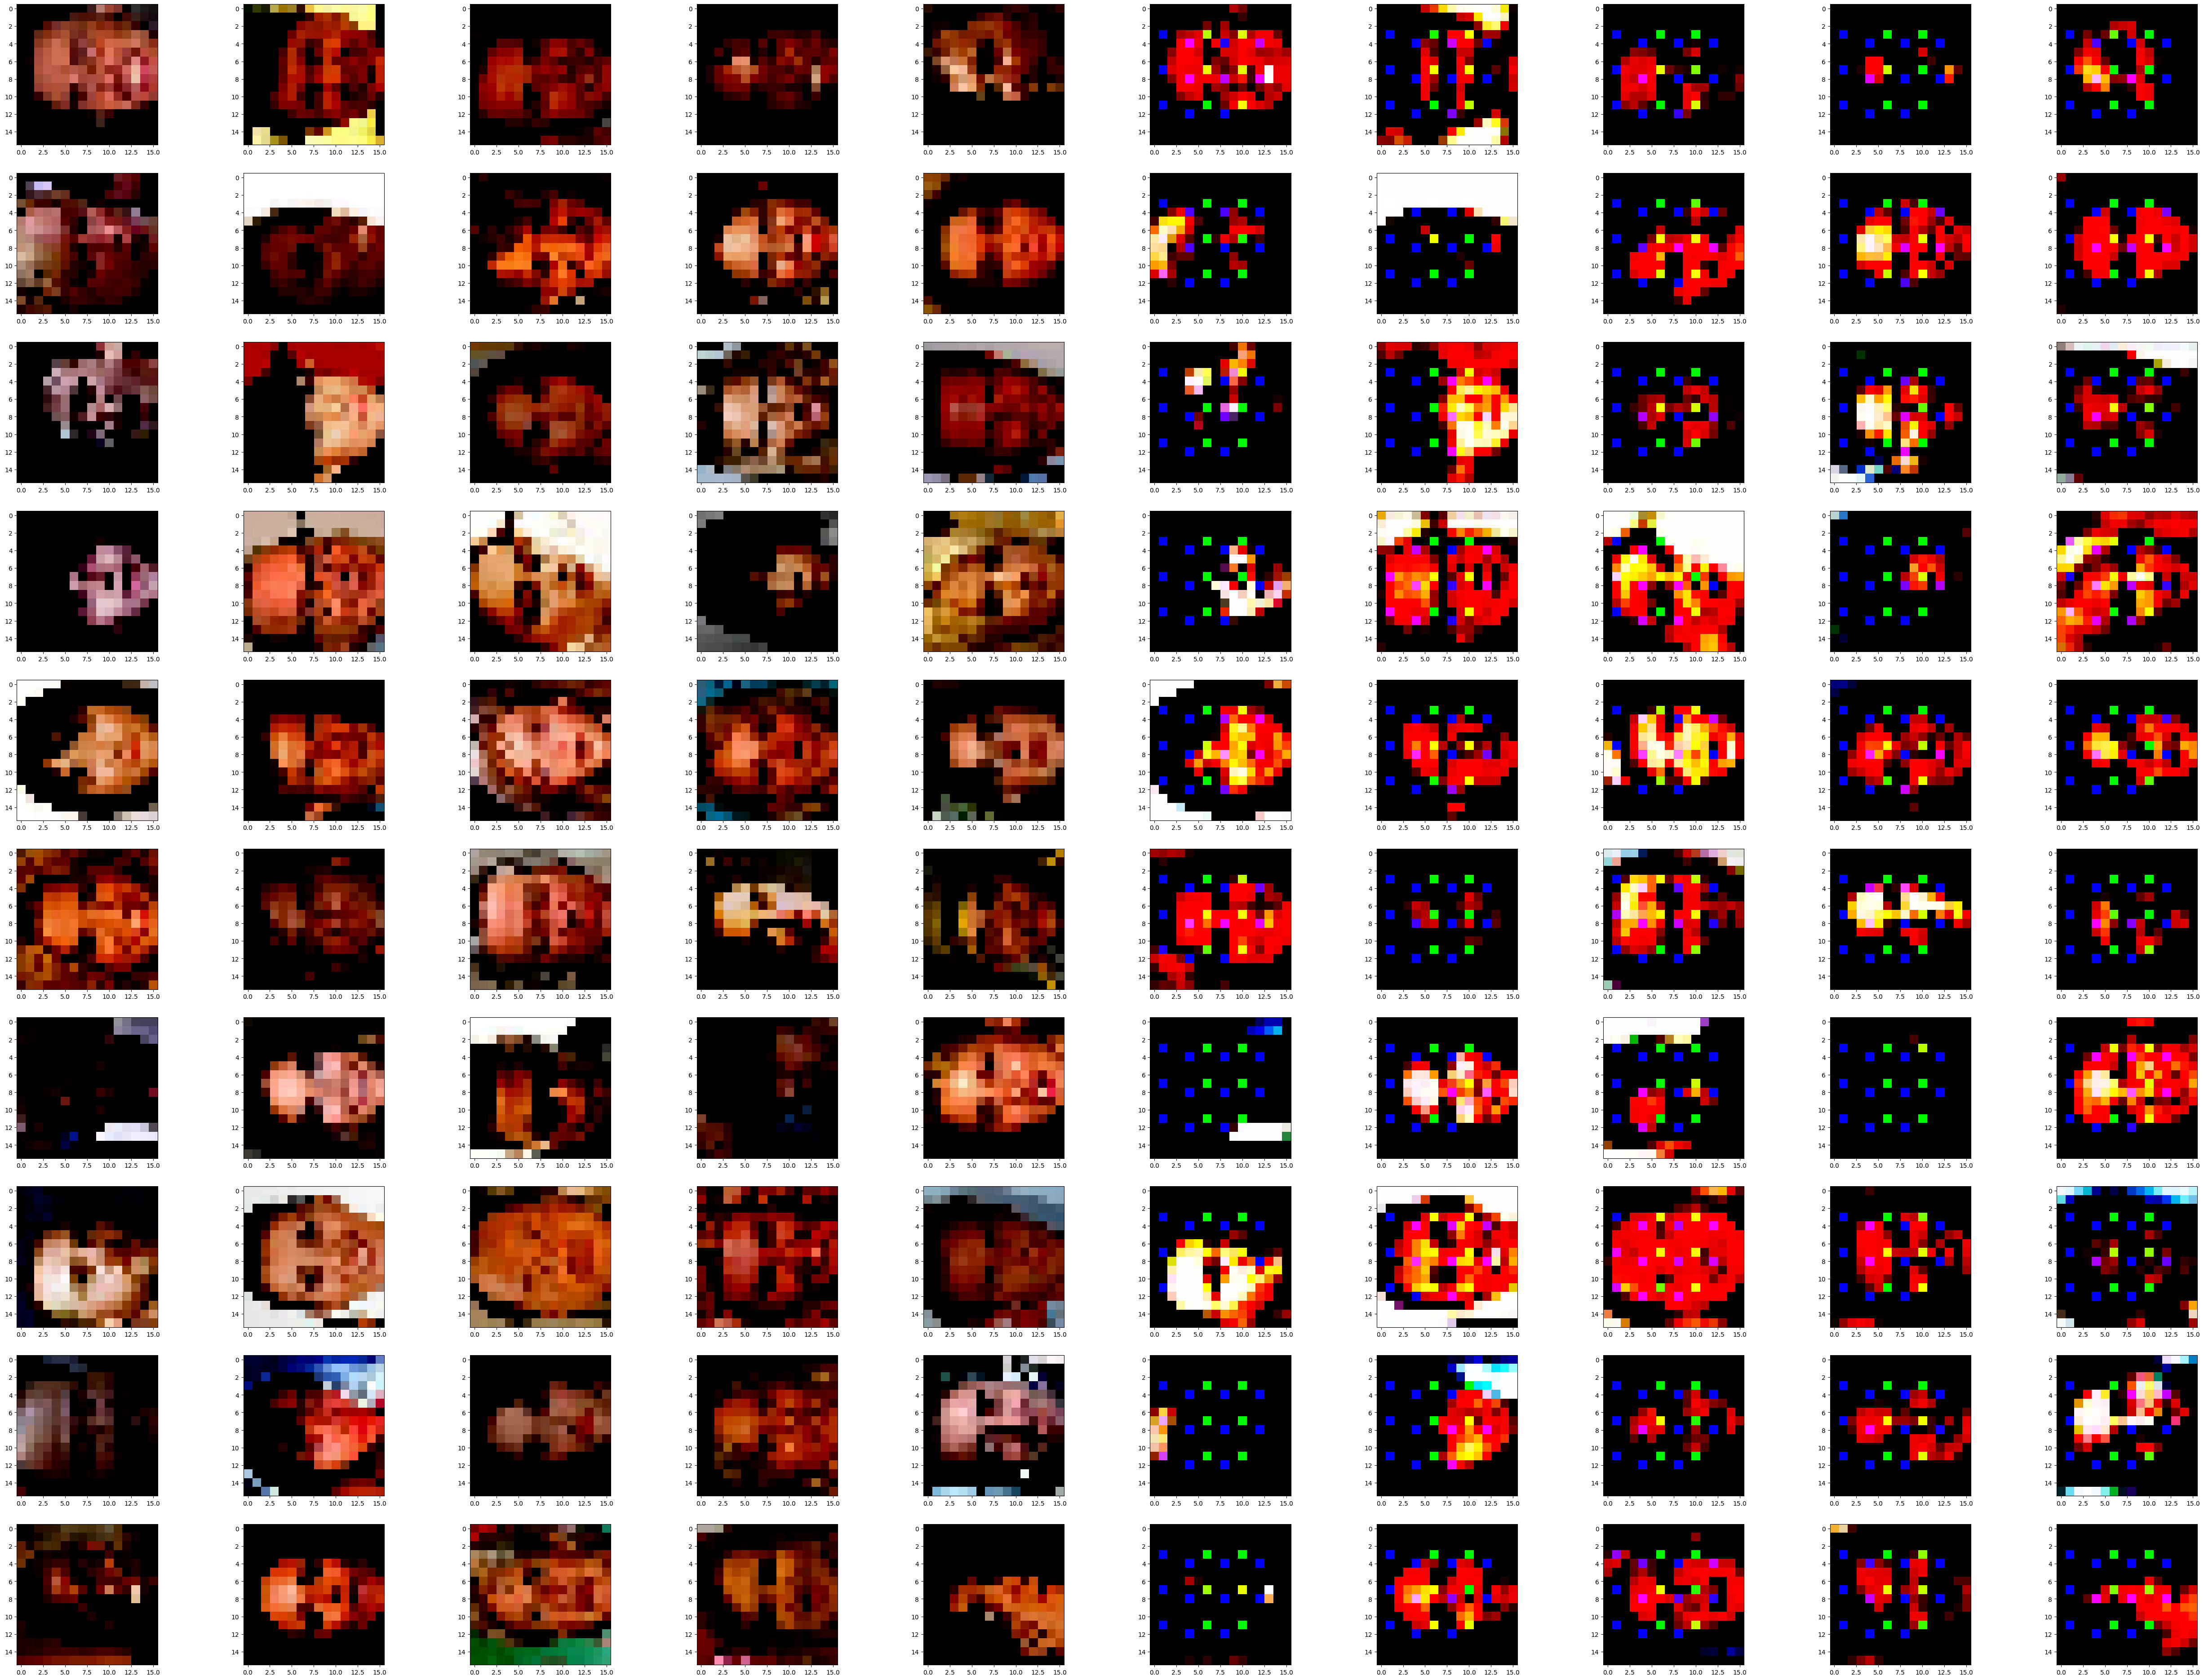

lol
Time elapsed: 12.98 min
Epoch: 002/002 | Batch 000/1582 | Gen/Dis Loss: 14.3723/0.0001
Epoch: 002/002 | Batch 050/1582 | Gen/Dis Loss: 116.6629/0.0000
Epoch: 002/002 | Batch 100/1582 | Gen/Dis Loss: 122.4207/0.0000
Epoch: 002/002 | Batch 150/1582 | Gen/Dis Loss: 12.5417/0.0000


KeyboardInterrupt: 

In [ ]:
### 
### FVAE  
### 

# model2=model
torch.autograd.set_detect_anomaly(True)
NUM_EPOCHS=2
DEVICE = ['cuda:0','cuda:0']
LEARNING_RATE = 0.0001
model=VAE_GAN1().to('cuda:0')
# model.generator=model1
# model.discriminator=model2.discriminator

model.to(DEVICE[0])


optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 
log_dict = train_vae_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
                         device=['cuda:0','cuda:0'], 
                        train_loader=train_loader,
                        logging_interval=50)
print(20*'=')
print(20*'END OF VAE')
print(20*'=')

